# Testing Student Performance Dataset

> Dataset: https://www.kaggle.com/datasets/dipam7/student-grade-prediction

- Goal of this notebook is to paste a template version of the workflow from the ADMIN_Comparing_Datasets notebook.
 
**The code will:**
- Create 4 preprocessing pipelines (one with scaling and one without)
    - `preprocessor`
        - Clone: `preprocessor_cln`
    - `preprocessor_scale`
        - Clone: `preprocessor_scale_cln`    
    
- Create 4 Versions of the X/y data.
    - **All Data/Rows:**
        - Starting Vars:
            - df,X,y, X_train, X_test,y_train,y_test
        - **Unscaled**
            - Without a  constant:
                - X_train_df, X_test_df, y_train,y_test
            - With a constant:
                - X_train_df_cnst, X_test_df_cnst, y_train (same), y_test (same)
        - **Scaled:**
            - Without a  constant:
                - X_train_df_scaled, X_test_df_scaled, y_train (same), y_test (same)
            - With a constant:
                - X_train_df_scaled_cnst, X_test_df_scaled_cnst, y_train (same), y_test (same)

    - **Cleaned/Outliers Removed**
        - Starting Vars:
            - df_clean,X_cln,y_cln, X_train_cln, X_test_cln,y_train_cln,y_test_cln
        - **Unscaled**
            - Without a  constant:
                - X_train_df_cln, X_test_df_cln, y_train,y_test
            - With a constant:
                - X_train_df_cln_cnst, X_test_df_cln_cnst, y_train_cln (same), y_test_cln (same)
        - **Scaled:**
            - Without a  constant:
                - X_train_df_cln_scaled, X_test_df_cln_scaled, y_train_cln (same), y_test_cln (same)
            - With a constant:
                - X_train_df_scaled_cln_cnst, X_test_df_cln_scaled_cnst, y_train_cln (same), y_test_cln (same)

# Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from sklearn.base import clone

## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm
from scipy import stats

## Customized Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
# plt.style.use('seaborn-talk')

In [2]:
## Adding folder above to path
import os, sys
sys.path.append(os.path.abspath('../'))

## Load stack_functions with autoreload turned on
%load_ext autoreload
%autoreload 2
from CODE import stack_functions as sf

def show_code(function):
    import inspect 
    from IPython.display import display,Markdown, display_markdown
    code = inspect.getsource(function)
    md_txt = f"```python\n{code}\n```"
    return display(Markdown(md_txt))
    

## Preliminary Checks and Dtype Conversion

- Change:
    - `FILE`: url or filepath to load
    - `DROP_COLS`: list of columns to drop from df
    - `CONVERT_TO_STR_COLS`: numeric cols to convert to str
    - `CONVERT_TO_NUM_COLS`: str cols to convert to numeric (uses pd.to_numeric)

In [3]:
## Load in data
FILE = "../Data/student_data.csv"


df = pd.read_csv(FILE)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother           2          2         0       yes     no   no   
1  course   father           1          2         0        no    yes   no   
2   other   mother           1          2         3       yes     no  yes   
3    home   mother           1          3         0        no    yes  yes   
4    home   father           1          2         0        no    yes  yes   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \
0         no     yes    yes       no       no       4         3      4     1   
1         no      no    yes      yes       no       5         3      3     1   
2         no     yes    yes      yes       no       4         3      2     2   
3        yes     yes    yes      yes      yes       3         2      2     1   
4         no     yes    yes       no       no       4         3      2     1   

   Walc  health  absences  G1  G2  G3  
0     1       3         6   5   6   6  
1     1       3         4   5   5   6  
2     3       3        10   7   8  10  
3     1       5         2  15  14  15  
4     2       5         4   6  10  10

In [4]:
from pandas_profiling import ProfileReport
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
## Drop unwanted columns
DROP_COLS = []#'id','date']
df = df.drop(columns=DROP_COLS)

In [6]:
## Convert all categories to strings
CONVERT_TO_STR_COLS = []#'zipcode']
df[CONVERT_TO_STR_COLS] = df[CONVERT_TO_STR_COLS].astype(str)

CONVERT_TO_NUM_COLS = []
for col in CONVERT_TO_NUM_COLS:
    df[col] = pd.to_numeric(df[col])

In [7]:
## final info before X/y
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

## Full Dataset Preprocessing

In [8]:
## Make x and y variables
target = 'G3'
drop_cols_model = []


y = df[target].copy()
X = df.drop(columns=[target,*drop_cols_model]).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob     Fjob  \
215     GP   F   17       U     LE3       T     3     2    other    other   
48      GP   M   15       U     GT3       T     4     2  teacher    other   
303     GP   F   17       U     GT3       T     3     2   health   health   
160     GP   M   17       R     LE3       T     2     1  at_home    other   
60      GP   F   16       R     GT3       T     4     4   health  teacher   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
215  reputation   mother           2          2         0        no     no   
48         home   mother           1          2         0        no    yes   
303  reputation   father           1          4         0        no    yes   
160      course   mother           2          1         2        no     no   
60        other   mother           1          2         0        no    yes   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
215  yes         no     yes    yes      yes       no       4         4      4   
48   yes         no     yes    yes       no       no       4         3      3   
303  yes        yes      no    yes      yes       no       5         2      2   
160   no        yes     yes     no      yes      yes       3         3      2   
60    no        yes     yes    yes       no       no       2         4      4   

     Dalc  Walc  health  absences  G1  G2  
215     1     3       1         2  14  15  
48      2     2       5         2  15  15  
303     1     2       5         0  17  17  
160     2     2       5         0   7   6  
60      2     3       4         6  10  11

### Unscaled

In [9]:
## cat selector
cat_sel = make_column_selector(dtype_include='object')
cat_cols = cat_sel(X)

# num selectorr
num_sel = make_column_selector(dtype_include='number')
num_cols = num_sel(X)

## make pipelines & column transformer - raw numeric
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_pipe_raw = make_pipeline(SimpleImputer(strategy='mean'))
preprocessor = make_column_transformer((num_pipe_raw, num_sel),
                                       (cat_pipe,cat_sel), verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14fac1730>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14fac1d30>)],
                  verbose_feature_names_out=False)

In [10]:
### PREP ALL X VARS
## Prepare X_train_df
X_train_df = pd.DataFrame( preprocessor.fit_transform(X_train), 
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)

## Prepare X_test_df
X_test_df = pd.DataFrame( preprocessor.transform(X_test),
                         columns=preprocessor.get_feature_names_out(), 
                         index=X_test.index)


## Prepare X vars with constant
X_train_df_cnst = sm.add_constant(X_train_df, prepend=False, has_constant='add')
X_test_df_cnst = sm.add_constant(X_test_df, prepend=False, has_constant='add')

In [11]:
X_train_df.describe()

age        Medu        Fedu  traveltime   studytime    failures  \
count  296.000000  296.000000  296.000000   296.00000  296.000000  296.000000   
mean    16.689189    2.760135    2.533784     1.47973    2.010135    0.320946   
std      1.303718    1.092299    1.088713     0.74077    0.837611    0.723715   
min     15.000000    0.000000    0.000000     1.00000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000     1.00000    1.000000    0.000000   
50%     17.000000    3.000000    2.500000     1.00000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000     2.00000    2.000000    0.000000   
max     22.000000    4.000000    4.000000     4.00000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  296.000000  296.000000  296.000000  296.000000  296.000000  296.000000   
mean     3.932432    3.175676    3.060811    1.466216    2.287162    3.543919   
std      0.906939    1.013243    1.127327    0.889986    1.313026    1.411129   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    2.000000    1.000000    1.000000    3.000000   
50%      4.000000    3.000000    3.000000    1.000000    2.000000    4.000000   
75%      5.000000    4.000000    4.000000    2.000000    3.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

         absences          G1          G2   school_GP   school_MS       sex_F  \
count  296.000000  296.000000  296.000000  296.000000  296.000000  296.000000   
mean     5.679054   10.871622   10.645270    0.881757    0.118243    0.520270   
std      7.907197    3.362365    3.854891    0.323443    0.323443    0.500435   
min      0.000000    3.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    8.000000    8.000000    1.000000    0.000000    0.000000   
50%      4.000000   11.000000   11.000000    1.000000    0.000000    1.000000   
75%      8.000000   13.000000   13.000000    1.000000    0.000000    1.000000   
max     75.000000   19.000000   19.000000    1.000000    1.000000    1.000000   

            sex_M   address_R   address_U  famsize_GT3  famsize_LE3  \
count  296.000000  296.000000  296.000000   296.000000   296.000000   
mean     0.479730    0.229730    0.770270     0.722973     0.277027   
std      0.500435    0.421371    0.421371     0.448288     0.448288   
min      0.000000    0.000000    0.000000     0.000000     0.000000   
25%      0.000000    0.000000    1.000000     0.000000     0.000000   
50%      0.000000    0.000000    1.000000     1.000000     0.000000   
75%      1.000000    0.000000    1.000000     1.000000     1.000000   
max      1.000000    1.000000    1.000000     1.000000     1.000000   

        Pstatus_A   Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
count  296.000000  296.000000    296.000000   296.000000  296.000000   
mean     0.104730    0.895270      0.162162     0.074324    0.337838   
std      0.306723    0.306723      0.369224     0.262742    0.473774   
min      0.000000    0.000000      0.000000     0.000000    0.000000   
25%      0.000000    1.000000      0.000000     0.000000    0.000000   
50%      0.000000    1.000000      0.000000     0.000000    0.000000   
75%      0.000000    1.000000      0.000000     0.000000    1.000000   
max      1.000000    1.000000      1.000000     1.000000    1.000000   

       Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
count     296.000000    296.000000    296.000000   296.000000  296.000000   
mean        0.270270      0.155405      0.054054     0.050676    0.530405   
std         0.444851      0.362904      0.226507     0.219706    0.499920   
min         0.000000      0.000000      0.000000     0.000000    0.000000   
25%         0.000000      0.000000      0.000000     0.000000    0.000000   
50%         0.000000      0.000000      0.000000     0.000000    1.000000

> The cell below should be updated for each dataset- only separating high cardinality OHE features (e.g. zipcode)

In [12]:
## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_df.columns if c.startswith('zipcode')]
nonohe_cols = X_train_df.drop(columns=[*ohe_cols]).columns.tolist()

### Scaled

In [13]:
## make pipelines & column transformer - scaled
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe_scale = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
preprocessor_scale = make_column_transformer((num_pipe_scale, num_sel),
                                       (cat_pipe,cat_sel), verbose_feature_names_out=False)
preprocessor_scale

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14fac1730>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14fac1d30>)],
                  verbose_feature_names_out=False)

In [14]:
# ### PREP ALL SCALED X VARS


# Prepare X_train_scaled_df & X_test_scaled_df
X_train_scaled_df = pd.DataFrame( preprocessor_scale.fit_transform(X_train), 
                          columns=preprocessor_scale.get_feature_names_out(),
                         index=X_train.index)


X_test_scaled_df = pd.DataFrame( preprocessor_scale.transform(X_test),
                         columns=preprocessor_scale.get_feature_names_out(), 
                         index=X_test.index)


## Save vers with constant
X_train_scaled_df_cnst = sm.add_constant(X_train_scaled_df, prepend=False, has_constant='add')
X_test_scaled_df_cnst = sm.add_constant(X_test_scaled_df, prepend=False, has_constant='add')


## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_df.columns if c.startswith('zipcode')]
nonohe_cols = X_train_df.drop(columns=[*ohe_cols]).columns.tolist()


X_test_scaled_df.head()

age      Medu      Fedu  traveltime  studytime  failures    famrel  \
58  -1.297865 -1.614133 -0.491119   -0.648706  -0.012121 -0.444221  0.074627   
338  1.007144  0.219968  0.428952   -0.648706   2.379667 -0.444221  1.179104   
291  0.238807  1.137019  0.428952   -0.648706   1.183773 -0.444221  0.074627   
281  0.238807  0.219968 -0.491119   -0.648706  -1.208014  0.939879  0.074627   
322  0.238807 -0.697082 -0.491119   -0.648706   1.183773 -0.444221 -1.029851   

     freetime     goout      Dalc      Walc    health  absences        G1  \
58  -0.173673 -0.942590 -0.524734 -0.981962  1.033603 -0.466067 -0.557581   
338 -0.173673 -0.054034 -0.524734 -0.981962 -1.805807  0.167339  1.527813   
291 -1.162275 -0.942590 -0.524734 -0.219073 -0.386102 -0.719430  1.229899   
281  0.814929  0.834523  1.726298  1.306705 -0.386102  1.687514  0.038246   
322 -0.173673 -0.942590  0.600782 -0.219073 -0.386102 -0.339386  0.038246   

           G2  school_GP  school_MS  sex_F  sex_M  address_R  address_U  \
58  -0.167674        1.0        0.0    0.0    1.0        0.0        1.0   
338  1.131577        1.0        0.0    1.0    0.0        0.0        1.0   
291  1.131577        1.0        0.0    1.0    0.0        0.0        1.0   
281 -0.427524        1.0        0.0    0.0    1.0        0.0        1.0   
322  0.092177        1.0        0.0    1.0    0.0        1.0        0.0   

     famsize_GT3  famsize_LE3  Pstatus_A  Pstatus_T  Mjob_at_home  \
58           0.0          1.0        0.0        1.0           0.0   
338          0.0          1.0        0.0        1.0           0.0   
291          1.0          0.0        0.0        1.0           0.0   
281          0.0          1.0        1.0        0.0           0.0   
322          0.0          1.0        0.0        1.0           0.0   

     Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  Fjob_at_home  \
58           0.0         1.0            0.0           0.0           1.0   
338          0.0         0.0            1.0           0.0           0.0   
291          1.0         0.0            0.0           0.0           0.0   
281          0.0         0.0            0.0           1.0           0.0   
322          0.0         0.0            1.0           0.0           0.0   

     Fjob_health  Fjob_other  Fjob_services  Fjob_teacher  reason_course  \
58           0.0         0.0            0.0           0.0            0.0   
338          0.0         0.0            1.0           0.0            0.0   
291          0.0         0.0            1.0           0.0            0.0   
281          0.0         0.0            1.0           0.0            0.0   
322          0.0         0.0            1.0           0.0            1.0   

     reason_home  reason_other  reason_reputation  guardian_father  \
58           1.0           0.0                0.0              1.0   
338          1.0           0.0                0.0              0.0   
291          0.0           0.0                1.0              0.0   
281          1.0           0.0                0.0              0.0   
322          0.0           0.0                0.0              0.0   

     guardian_mother  guardian_other  schoolsup_no  schoolsup_yes  famsup_no  \
58               0.0             0.0           0.0            1.0        0.0   
338              1.0             0.0           1.0            0.0        0.0   
291              1.0             0.0           1.0            0.0        0.0   
281              1.0             0.0           1.0            0.0        1.0   
322              1.0             0.0           1.0            0.0        0.0   

     famsup_yes  paid_no  paid_yes  activities_no  activities_yes  nursery_no  \
58          1.0      1.0       0.0            0.0             1.0         0.0   
338         1.0      1.0       0.0            1.0             0.0         0.0   
291         1.0      0.0       1.0            1.0             0.0         0.0   
281         0.0      1.0       0.0            1.0             0.0 

In [15]:
X_train_scaled_df.describe()

age          Medu          Fedu    traveltime     studytime  \
count  2.960000e+02  2.960000e+02  2.960000e+02  2.960000e+02  2.960000e+02   
mean  -1.830368e-16  3.450693e-17  2.400482e-17 -1.650332e-16 -2.250452e-18   
std    1.001693e+00  1.001693e+00  1.001693e+00  1.001693e+00  1.001693e+00   
min   -1.297865e+00 -2.531183e+00 -2.331262e+00 -6.487062e-01 -1.208014e+00   
25%   -5.295291e-01 -6.970824e-01 -4.911192e-01 -6.487062e-01 -1.208014e+00   
50%    2.388072e-01  2.199682e-01 -3.108349e-02 -6.487062e-01 -1.212054e-02   
75%    1.007144e+00  1.137019e+00  4.289522e-01  7.035265e-01 -1.212054e-02   
max    4.080489e+00  1.137019e+00  1.349024e+00  3.407992e+00  2.379667e+00   

           failures        famrel      freetime         goout          Dalc  \
count  2.960000e+02  2.960000e+02  2.960000e+02  2.960000e+02  2.960000e+02   
mean  -2.400482e-17 -3.300663e-17 -2.235449e-16 -1.530307e-16 -6.001206e-18   
std    1.001693e+00  1.001693e+00  1.001693e+00  1.001693e+00  1.001693e+00   
min   -4.442212e-01 -3.238806e+00 -2.150877e+00 -1.831147e+00 -5.247338e-01   
25%   -4.442212e-01  7.462687e-02 -1.736733e-01 -9.425902e-01 -5.247338e-01   
50%   -4.442212e-01  7.462687e-02 -1.736733e-01 -5.403384e-02 -5.247338e-01   
75%   -4.442212e-01  1.179104e+00  8.149285e-01  8.345226e-01  6.007822e-01   
max    3.708078e+00  1.179104e+00  1.803530e+00  1.723079e+00  3.977330e+00   

               Walc        health      absences            G1            G2  \
count  2.960000e+02  2.960000e+02  2.960000e+02  2.960000e+02  2.960000e+02   
mean  -8.701748e-17  7.201447e-17 -6.601326e-17  1.740350e-16  1.800362e-17   
std    1.001693e+00  1.001693e+00  1.001693e+00  1.001693e+00  1.001693e+00   
min   -9.819620e-01 -1.805807e+00 -7.194296e-01 -2.345061e+00 -2.766174e+00   
25%   -9.819620e-01 -3.861022e-01 -7.194296e-01 -8.554945e-01 -6.873736e-01   
50%   -2.190729e-01  3.237503e-01 -2.127046e-01  3.824564e-02  9.217654e-02   
75%    5.438162e-01  1.033603e+00  2.940203e-01  6.340724e-01  6.118766e-01   
max    2.069595e+00  1.033603e+00  8.781663e+00  2.421553e+00  2.170977e+00   

        school_GP   school_MS       sex_F       sex_M   address_R   address_U  \
count  296.000000  296.000000  296.000000  296.000000  296.000000  296.000000   
mean     0.881757    0.118243    0.520270    0.479730    0.229730    0.770270   
std      0.323443    0.323443    0.500435    0.500435    0.421371    0.421371   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
50%      1.000000    0.000000    1.000000    0.000000    0.000000    1.000000   
75%      1.000000    0.000000    1.000000    1.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       famsize_GT3  famsize_LE3   Pstatus_A   Pstatus_T  Mjob_at_home  \
count   296.000000   296.000000  296.000000  296.000000    296.000000   
mean      0.722973     0.277027    0.104730    0.895270      0.162162   
std       0.448288     0.448288    0.306723    0.306723      0.369224   
min       0.000000     0.000000    0.000000    0.000000      0.000000   
25%       0.000000     0.000000    0.000000    1.000000      0.000000   
50%       1.000000     0.000000    0.000000    1.000000      0.000000   
75%       1.000000     1.000000    0.000000    1.000000      0.000000   
max       1.000000     1.000000    1.000000    1.000000      1.000000   

       Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  Fjob_at_home  \
count   296.000000  296.000000     296.000000    296.000000    296.000000   
mean      0.074324    0.337838       0.270270      0.155405      0.054054   
std       0.262742    0.473774       0.444851      0.362904      0.226507   
min       0.000000    0.000000       0.000000      0.000000      0.000000   
25%       0.000000    0.000000       0.000000      0.000000      0.000000   
50%       0.000000    0.000000

## Cleaned Dataset Preprocessing

### Remove Outliers

In [16]:
show_code(sf.remove_outliers)

```python
def remove_outliers(df_,method='iqr', subset=None, verbose=2):
    """Returns a copy of the input df with outleirs removed from all
    columns using the selected method (either 'iqr' or 'z'/'zscore')
    
    Arguments:
        df_ (Frame): Dataframe to copy and remove outleirs from
        method (str): Method of outlier removal. Options are 'iqr' or 'z' (default is 'iqr')
        subset (list or None): List of column names to remove outliers from. If None, uses all numeric columns.
        verbose (bool, int): If verbose==1, print only overall summary. If verbose==2, print detailed summary"""
    import pandas as pd
    ## Make a cope of input dataframe  
    df = df_.copy()
    
    ## Set verbose_func for calls to outleir funcs
    if verbose==2:
        verbose_func = True
    else:
        verbose_func=False
        
    ## Set outlier removal function and name
    if method.lower()=='iqr':
        find_outlier_func = find_outliers_IQR
        method_name = "IQR rule"
    elif 'z' in method.lower():
        find_outlier_func = find_outliers_Z
        method_name = 'Z_score rule'
    else:
        raise Exception('[!] Method must be either "iqr" or "z".')
        
    ## Set list of cols to remove outliers from
    if subset is None:
        col_list = df.select_dtypes('number').columns
    elif isinstance(subset,str):
        col_list = [subset]
    elif isinstance(susbet, list):
        col_list = subset
    else:
        raise Exception("[!] subset must be None, a single string, or a list of strings.")

    

    
    ## Empty dict for both types of outliers
    outliers = {}

    ## Use both functions to see the comparison for # of outliers
    for col in col_list:
        idx_outliers = find_outlier_func(df[col],verbose=verbose_func)
        outliers[col] = idx_outliers

    
    ## Getting final df of all outliers to get 1 final T/F index
    outliers_combined = pd.DataFrame(outliers).any(axis=1)
    
    if verbose:
        n = len(outliers_combined)
        print(f"\n[i] Overall, {outliers_combined.sum():,} rows out of {n:,}({outliers_combined.sum()/n*100:.2f}%) were removed as outliers using {method_name}.")
    
    
    # remove_outliers 
    df_clean = df[~outliers_combined].copy()
    return df_clean

```

In [17]:
df_clean_iqr = sf.remove_outliers(df,verbose=2)
df_clean_iqr

- 1 outliers found in age out of 395 rows (0.25%) using IQR.
- 0 outliers found in Medu out of 395 rows (0.00%) using IQR.
- 2 outliers found in Fedu out of 395 rows (0.51%) using IQR.
- 8 outliers found in traveltime out of 395 rows (2.03%) using IQR.
- 27 outliers found in studytime out of 395 rows (6.84%) using IQR.
- 83 outliers found in failures out of 395 rows (21.01%) using IQR.
- 26 outliers found in famrel out of 395 rows (6.58%) using IQR.
- 19 outliers found in freetime out of 395 rows (4.81%) using IQR.
- 0 outliers found in goout out of 395 rows (0.00%) using IQR.
- 18 outliers found in Dalc out of 395 rows (4.56%) using IQR.
- 0 outliers found in Walc out of 395 rows (0.00%) using IQR.
- 0 outliers found in health out of 395 rows (0.00%) using IQR.
- 15 outliers found in absences out of 395 rows (3.80%) using IQR.
- 0 outliers found in G1 out of 395 rows (0.00%) using IQR.
- 13 outliers found in G2 out of 395 rows (3.29%) using IQR.
- 0 outliers found in G3 out of 395 row

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
5       GP   M   16       U     LE3       T     4     3  services     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
385     MS   F   18       R     GT3       T     2     2   at_home     other   
386     MS   F   18       R     GT3       T     4     4   teacher   at_home   
388     MS   F   18       U     LE3       T     3     1   teacher  services   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
0        course   mother           2          2         0       yes     no   
1        course   father           1          2         0        no    yes   
3          home   mother           1          3         0        no    yes   
4          home   father           1          2         0        no    yes   
5    reputation   mother           1          2         0        no    yes   
..          ...      ...         ...        ...       ...       ...    ...   
385       other   mother           2          3         0        no     no   
386  reputation   mother           3          1         0        no    yes   
388      course   mother           1          2         0        no    yes   
393      course   mother           3          1         0        no     no   
394      course   father           1          1         0        no     no   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
0     no         no     yes    yes       no       no       4         3      4   
1     no         no      no    yes      yes       no       5         3      3   
3    yes        yes     yes    yes      yes      yes       3         2      2   
4    yes         no     yes    yes       no       no       4         3      2   
5    yes        yes     yes    yes      yes       no       5         4      2   
..   ...        ...     ...    ...      ...      ...     ...       ...    ...   
385  yes         no     yes    yes       no       no       5         3      3   
386  yes        yes     yes    yes      yes      yes       4         4      3   
388  yes         no     yes    yes      yes       no       4         3      4   
393   no         no      no    yes      yes       no       4         4      1   
394   no         no     yes    yes      yes       no       3         2      3   

     Dalc  Walc  health  absences  G1  G2  G3  
0       1     1       3         6   5   6   6  
1       1     1       3         4   5   5   6  
3       1     1       5         2  15  14  15  
4       1     2       5         4   6  10  10  
5       1     2       5        10  15  15  15  
..    ...   ...     ...       ...  ..  ..  ..  
385     1     3       4         2  10   9  10  
386     2     2       5         7   6   5   6  
388     1     1       1         0   7   9   8  
393     3     4       5         0  11  12  10  
394     3     3       5         5   8   9   9  

[232 rows x 33 columns]

In [18]:
df_clean_z = sf.remove_outliers(df,method='z')
df_clean_z

- 2 outliers found in age out of 395 rows (0.51%) using Z-scores.
- 0 outliers found in Medu out of 395 rows (0.00%) using Z-scores.
- 0 outliers found in Fedu out of 395 rows (0.00%) using Z-scores.
- 8 outliers found in traveltime out of 395 rows (2.03%) using Z-scores.
- 0 outliers found in studytime out of 395 rows (0.00%) using Z-scores.
- 16 outliers found in failures out of 395 rows (4.05%) using Z-scores.
- 8 outliers found in famrel out of 395 rows (2.03%) using Z-scores.
- 0 outliers found in freetime out of 395 rows (0.00%) using Z-scores.
- 0 outliers found in goout out of 395 rows (0.00%) using Z-scores.
- 9 outliers found in Dalc out of 395 rows (2.28%) using Z-scores.
- 0 outliers found in Walc out of 395 rows (0.00%) using Z-scores.
- 0 outliers found in health out of 395 rows (0.00%) using Z-scores.
- 6 outliers found in absences out of 395 rows (1.52%) using Z-scores.
- 0 outliers found in G1 out of 395 rows (0.00%) using Z-scores.
- 0 outliers found in G2 out of 395 

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
5       GP   M   16       U     LE3       T     4     3  services     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
388     MS   F   18       U     LE3       T     3     1   teacher  services   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
0        course   mother           2          2         0       yes     no   
1        course   father           1          2         0        no    yes   
3          home   mother           1          3         0        no    yes   
4          home   father           1          2         0        no    yes   
5    reputation   mother           1          2         0        no    yes   
..          ...      ...         ...        ...       ...       ...    ...   
388      course   mother           1          2         0        no    yes   
390      course    other           1          2         2        no    yes   
391      course   mother           2          1         0        no     no   
393      course   mother           3          1         0        no     no   
394      course   father           1          1         0        no     no   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
0     no         no     yes    yes       no       no       4         3      4   
1     no         no      no    yes      yes       no       5         3      3   
3    yes        yes     yes    yes      yes      yes       3         2      2   
4    yes         no     yes    yes       no       no       4         3      2   
5    yes        yes     yes    yes      yes       no       5         4      2   
..   ...        ...     ...    ...      ...      ...     ...       ...    ...   
388  yes         no     yes    yes      yes       no       4         3      4   
390  yes         no     yes    yes       no       no       5         5      4   
391   no         no      no    yes      yes       no       2         4      5   
393   no         no      no    yes      yes       no       4         4      1   
394   no         no     yes    yes      yes       no       3         2      3   

     Dalc  Walc  health  absences  G1  G2  G3  
0       1     1       3         6   5   6   6  
1       1     1       3         4   5   5   6  
3       1     1       5         2  15  14  15  
4       1     2       5         4   6  10  10  
5       1     2       5        10  15  15  15  
..    ...   ...     ...       ...  ..  ..  ..  
388     1     1       1         0   7   9   8  
390     4     5       4        11   9   9   9  
391     3     4       2         3  14  16  16  
393     3     4       5         0  11  12  10  
394     3     3       5         5   8   9   9  

[355 rows x 33 columns]

In [19]:
## Make x and y variables
# target = 'price'
# drop_cols_model = []

y_cln = df_clean_z[target].copy()
X_cln = df_clean_z.drop(columns=[target,*drop_cols_model]).copy()

X_train_cln, X_test_cln, y_train_cln, y_test_cln = train_test_split(X_cln,y_cln, random_state=321)
X_train_cln.head()

school sex  age address famsize Pstatus  Medu  Fedu    Mjob      Fjob  \
44      GP   F   16       U     LE3       T     2     2   other   at_home   
27      GP   M   15       U     GT3       T     4     2  health  services   
77      GP   F   16       U     GT3       T     2     2   other     other   
384     MS   M   18       R     GT3       T     4     2   other     other   
253     GP   M   16       R     GT3       T     2     1   other     other   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
44       course   father           2          2         1       yes     no   
27        other   mother           1          1         0        no     no   
77   reputation   mother           1          4         0        no     no   
384        home   father           2          1         1        no     no   
253      course   mother           2          1         0        no     no   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
44    no        yes     yes    yes      yes       no       4         3      3   
27   yes         no     yes    yes      yes       no       2         2      4   
77   yes         no     yes    yes      yes      yes       5         2      3   
384  yes         no     yes    yes       no       no       5         4      3   
253   no        yes      no    yes       no       no       3         3      2   

     Dalc  Walc  health  absences  G1  G2  
44      2     2       5        14  10  10  
27      2     4       1         4  15  16  
77      1     3       3         0  11  11  
384     4     3       3        14   6   5  
253     1     3       3         0   8   9

### Unscaled

In [20]:
## Cloning the Previous 2 Preprocessors
preprocessor_cln = clone(preprocessor)
preprocessor_cln_scale = clone(preprocessor_scale)

In [21]:
### PREP ALL X VARS
## Prepare X_train_df
X_train_df_cln = pd.DataFrame( preprocessor_cln.fit_transform(X_train_cln), 
                          columns=preprocessor_cln.get_feature_names_out(),
                         index=X_train_cln.index)

## Prepare X_test_df
X_test_df_cln = pd.DataFrame( preprocessor_cln.transform(X_test_cln),
                         columns=preprocessor_cln.get_feature_names_out(), 
                         index=X_test_cln.index)


## Prepare X vars with constant
X_train_df_cln_cnst = sm.add_constant(X_train_df_cln, prepend=False, has_constant='add')
X_test_df_cln_cnst = sm.add_constant(X_test_df_cln, prepend=False, has_constant='add')


## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_df_cln.columns if c.startswith('zipcode')]
nonohe_cols = X_train_df_cln.drop(columns=[*ohe_cols]).columns.tolist()

X_test_df.head()

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
58   15.0   1.0   2.0         1.0        2.0       0.0     4.0       3.0   
338  18.0   3.0   3.0         1.0        4.0       0.0     5.0       3.0   
291  17.0   4.0   3.0         1.0        3.0       0.0     4.0       2.0   
281  17.0   3.0   2.0         1.0        1.0       1.0     4.0       4.0   
322  17.0   2.0   2.0         1.0        3.0       0.0     3.0       3.0   

     goout  Dalc  Walc  health  absences    G1    G2  school_GP  school_MS  \
58     2.0   1.0   1.0     5.0       2.0   9.0  10.0        1.0        0.0   
338    3.0   1.0   1.0     1.0       7.0  16.0  15.0        1.0        0.0   
291    2.0   1.0   2.0     3.0       0.0  15.0  15.0        1.0        0.0   
281    4.0   3.0   4.0     3.0      19.0  11.0   9.0        1.0        0.0   
322    2.0   2.0   2.0     3.0       3.0  11.0  11.0        1.0        0.0   

     sex_F  sex_M  address_R  address_U  famsize_GT3  famsize_LE3  Pstatus_A  \
58     0.0    1.0        0.0        1.0          0.0          1.0        0.0   
338    1.0    0.0        0.0        1.0          0.0          1.0        0.0   
291    1.0    0.0        0.0        1.0          1.0          0.0        0.0   
281    0.0    1.0        0.0        1.0          0.0          1.0        1.0   
322    1.0    0.0        1.0        0.0          0.0          1.0        0.0   

     Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  Mjob_services  \
58         1.0           0.0          0.0         1.0            0.0   
338        1.0           0.0          0.0         0.0            1.0   
291        1.0           0.0          1.0         0.0            0.0   
281        0.0           0.0          0.0         0.0            0.0   
322        1.0           0.0          0.0         0.0            1.0   

     Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  Fjob_services  \
58            0.0           1.0          0.0         0.0            0.0   
338           0.0           0.0          0.0         0.0            1.0   
291           0.0           0.0          0.0         0.0            1.0   
281           1.0           0.0          0.0         0.0            1.0   
322           0.0           0.0          0.0         0.0            1.0   

     Fjob_teacher  reason_course  reason_home  reason_other  \
58            0.0            0.0          1.0           0.0   
338           0.0            0.0          1.0           0.0   
291           0.0            0.0          0.0           0.0   
281           0.0            0.0          1.0           0.0   
322           0.0            1.0          0.0           0.0   

     reason_reputation  guardian_father  guardian_mother  guardian_other  \
58                 0.0              1.0              0.0             0.0   
338                0.0              0.0              1.0             0.0   
291                1.0              0.0              1.0             0.0   
281                0.0              0.0              1.0             0.0   
322                0.0              0.0              1.0             0.0   

     schoolsup_no  schoolsup_yes  famsup_no  famsup_yes  paid_no  paid_yes  \
58            0.0            1.0        0.0         1.0      1.0       0.0   
338           1.0            0.0        0.0         1.0      1.0       0.0   
291           1.0            0.0        0.0         1.0      0.0       1.0   
281           1.0            0.0        1.0         0.0      1.0       0.0   
322           1.0            0.0        0.0         1.0      0.0       1.0   

     activities_no  activities_yes  nursery_no  nursery_yes  higher_no  \
58             0.0             1.0         0.0          1.0        0.0   
338            1.0             0.0         0.0          1.0        0.0   
291            1.0             0.0         0.0          1.0        0.0   
281            1.0             0.0         0.0          1.0        0.0   
322            0.0             1.0      

In [22]:
X_train_df_cln.describe()

age        Medu        Fedu  traveltime   studytime    failures  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean    16.642857    2.736842    2.578947    1.413534    2.060150    0.214286   
std      1.164039    1.098161    1.054804    0.609705    0.812723    0.502017   
min     15.000000    0.000000    1.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
50%     17.000000    3.000000    3.000000    1.000000    2.000000    0.000000   
75%     17.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     20.000000    4.000000    4.000000    3.000000    4.000000    2.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean     3.984962    3.218045    3.056391    1.379699    2.214286    3.597744   
std      0.786537    0.938392    1.064264    0.696759    1.176477    1.359743   
min      2.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    2.000000    1.000000    1.000000    3.000000   
50%      4.000000    3.000000    3.000000    1.000000    2.000000    4.000000   
75%      5.000000    4.000000    4.000000    2.000000    3.000000    5.000000   
max      5.000000    5.000000    5.000000    4.000000    5.000000    5.000000   

         absences          G1          G2   school_GP   school_MS       sex_F  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean     5.093985   11.146617   10.939850    0.879699    0.120301    0.533835   
std      5.916606    3.324740    3.667829    0.325926    0.325926    0.499794   
min      0.000000    3.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    8.000000    9.000000    1.000000    0.000000    0.000000   
50%      4.000000   11.000000   11.000000    1.000000    0.000000    1.000000   
75%      7.750000   14.000000   13.000000    1.000000    0.000000    1.000000   
max     28.000000   19.000000   19.000000    1.000000    1.000000    1.000000   

            sex_M   address_R   address_U  famsize_GT3  famsize_LE3  \
count  266.000000  266.000000  266.000000   266.000000   266.000000   
mean     0.466165    0.233083    0.766917     0.706767     0.293233   
std      0.499794    0.423591    0.423591     0.456103     0.456103   
min      0.000000    0.000000    0.000000     0.000000     0.000000   
25%      0.000000    0.000000    1.000000     0.000000     0.000000   
50%      0.000000    0.000000    1.000000     1.000000     0.000000   
75%      1.000000    0.000000    1.000000     1.000000     1.000000   
max      1.000000    1.000000    1.000000     1.000000     1.000000   

        Pstatus_A   Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
count  266.000000  266.000000    266.000000   266.000000  266.000000   
mean     0.078947    0.921053      0.154135     0.105263    0.342105   
std      0.270165    0.270165      0.361759     0.307471    0.475309   
min      0.000000    0.000000      0.000000     0.000000    0.000000   
25%      0.000000    1.000000      0.000000     0.000000    0.000000   
50%      0.000000    1.000000      0.000000     0.000000    0.000000   
75%      0.000000    1.000000      0.000000     0.000000    1.000000   
max      1.000000    1.000000      1.000000     1.000000    1.000000   

       Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
count     266.000000    266.000000    266.000000   266.000000  266.000000   
mean        0.248120      0.150376      0.048872     0.045113    0.571429   
std         0.432736      0.358113      0.216007     0.207943    0.495805   
min         0.000000      0.000000      0.000000     0.000000    0.000000   
25%         0.000000      0.000000      0.000000     0.000000    0.000000   
50%         0.000000      0.000000      0.000000     0.000000    1.000000

### Scaled

In [23]:
# ### PREP ALL SCALED X VARS


# Prepare X_train_scaled_df & X_test_scaled_df
X_train_scaled_df_cln = pd.DataFrame( preprocessor_cln_scale.fit_transform(X_train_cln), 
                          columns=preprocessor_cln_scale.get_feature_names_out(),
                         index=X_train_cln.index)


X_test_scaled_df_cln = pd.DataFrame( preprocessor_cln_scale.transform(X_test_cln),
                         columns=preprocessor_cln_scale.get_feature_names_out(), 
                         index=X_test_cln.index)


## Save vers with constant
X_train_scaled_df_cln_cnst = sm.add_constant(X_train_scaled_df_cln, prepend=False, has_constant='add')
X_test_scaled_df_cln_cnst = sm.add_constant(X_test_scaled_df_cln, prepend=False, has_constant='add')


## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_scaled_df_cln.columns if c.startswith('zipcode')]
nonohe_cols = X_train_scaled_df_cln.drop(columns=[*ohe_cols]).columns.tolist()


X_train_scaled_df_cln.head()

age      Medu      Fedu  traveltime  studytime  failures    famrel  \
44  -0.553305 -0.672243 -0.549902    0.963698  -0.074150  1.568064  0.019155   
27  -1.414003  1.152416 -0.549902   -0.679530  -1.306901 -0.427654 -2.528429   
77  -0.553305 -0.672243 -0.549902   -0.679530   2.391350 -0.427654  1.292947   
384  1.168089  1.152416 -0.549902    0.963698  -1.306901  1.568064  1.292947   
253 -0.553305 -0.672243 -1.499732    0.963698  -1.306901 -0.427654 -1.254637   

     freetime     goout      Dalc      Walc    health  absences        G1  \
44  -0.232798 -0.053086  0.891944 -0.182485  1.033209  1.508095 -0.345524   
27  -1.300460  0.888302  0.891944  1.520711 -1.914069 -0.185249  1.161188   
77  -1.300460 -0.053086 -0.545978  0.669113 -0.440430 -0.862587 -0.044182   
384  0.834863 -0.053086  3.767788  0.669113 -0.440430  1.508095 -1.550894   
253 -0.232798 -0.994474 -0.545978  0.669113 -0.440430 -0.862587 -0.948209   

           G2  school_GP  school_MS  sex_F  sex_M  address_R  address_U  \
44  -0.256724        1.0        0.0    1.0    0.0        0.0        1.0   
27   1.382204        1.0        0.0    0.0    1.0        0.0        1.0   
77   0.016430        1.0        0.0    1.0    0.0        0.0        1.0   
384 -1.622498        0.0        1.0    0.0    1.0        1.0        0.0   
253 -0.529879        1.0        0.0    0.0    1.0        1.0        0.0   

     famsize_GT3  famsize_LE3  Pstatus_A  Pstatus_T  Mjob_at_home  \
44           0.0          1.0        0.0        1.0           0.0   
27           1.0          0.0        0.0        1.0           0.0   
77           1.0          0.0        0.0        1.0           0.0   
384          1.0          0.0        0.0        1.0           0.0   
253          1.0          0.0        0.0        1.0           0.0   

     Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  Fjob_at_home  \
44           0.0         1.0            0.0           0.0           1.0   
27           1.0         0.0            0.0           0.0           0.0   
77           0.0         1.0            0.0           0.0           0.0   
384          0.0         1.0            0.0           0.0           0.0   
253          0.0         1.0            0.0           0.0           0.0   

     Fjob_health  Fjob_other  Fjob_services  Fjob_teacher  reason_course  \
44           0.0         0.0            0.0           0.0            1.0   
27           0.0         0.0            1.0           0.0            0.0   
77           0.0         1.0            0.0           0.0            0.0   
384          0.0         1.0            0.0           0.0            0.0   
253          0.0         1.0            0.0           0.0            1.0   

     reason_home  reason_other  reason_reputation  guardian_father  \
44           0.0           0.0                0.0              1.0   
27           0.0           1.0                0.0              0.0   
77           0.0           0.0                1.0              0.0   
384          1.0           0.0                0.0              1.0   
253          0.0           0.0                0.0              0.0   

     guardian_mother  guardian_other  schoolsup_no  schoolsup_yes  famsup_no  \
44               0.0             0.0           0.0            1.0        1.0   
27               1.0             0.0           1.0            0.0        1.0   
77               1.0             0.0           1.0            0.0        1.0   
384              0.0             0.0           1.0            0.0        1.0   
253              1.0             0.0           1.0            0.0        1.0   

     famsup_yes  paid_no  paid_yes  activities_no  activities_yes  nursery_no  \
44          0.0      1.0       0.0            0.0             1.0         0.0   
27          0.0      0.0       1.0            1.0             0.0         0.0   
77          0.0      0.0       1.0            1.0             0.0         0.0   
384         0.0      0.0       1.0            1.0             0.0 

In [24]:
X_train_scaled_df_cln.describe()

age          Medu          Fedu    traveltime     studytime  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean   4.090295e-16 -3.005115e-17  1.335607e-17  4.841574e-17  2.671213e-17   
std    1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00   
min   -1.414003e+00 -2.496902e+00 -1.499732e+00 -6.795304e-01 -1.306901e+00   
25%   -5.533053e-01 -6.722428e-01 -5.499018e-01 -6.795304e-01 -7.415040e-02   
50%    3.073919e-01  2.400867e-01  3.999286e-01 -6.795304e-01 -7.415040e-02   
75%    3.073919e-01  1.152416e+00  3.999286e-01  9.636977e-01 -7.415040e-02   
max    2.889483e+00  1.152416e+00  1.349759e+00  2.606926e+00  2.391350e+00   

           failures        famrel      freetime         goout          Dalc  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean   5.342427e-17  9.349247e-17 -5.676328e-17 -4.340722e-17  4.173771e-17   
std    1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00   
min   -4.276537e-01 -2.528429e+00 -2.368122e+00 -1.935862e+00 -5.459779e-01   
25%   -4.276537e-01  1.915477e-02 -2.327985e-01 -9.944738e-01 -5.459779e-01   
50%   -4.276537e-01  1.915477e-02 -2.327985e-01 -5.308579e-02 -5.459779e-01   
75%   -4.276537e-01  1.292947e+00  8.348635e-01  8.883022e-01  8.919440e-01   
max    3.563781e+00  1.292947e+00  1.902525e+00  1.829690e+00  3.767788e+00   

               Walc        health      absences            G1            G2  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean  -1.368997e-16 -3.005115e-17 -3.339017e-18  5.175476e-17  1.235436e-16   
std    1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00   
min   -1.034083e+00 -1.914069e+00 -8.625869e-01 -2.454921e+00 -2.988272e+00   
25%   -1.034083e+00 -4.404297e-01 -8.625869e-01 -9.482090e-01 -5.298791e-01   
50%   -1.824853e-01  2.963898e-01 -1.852493e-01 -4.418178e-02  1.643036e-02   
75%    6.691127e-01  1.033209e+00  4.497547e-01  8.598454e-01  5.627399e-01   
max    2.372309e+00  1.033209e+00  3.878777e+00  2.366557e+00  2.201668e+00   

        school_GP   school_MS       sex_F       sex_M   address_R   address_U  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean     0.879699    0.120301    0.533835    0.466165    0.233083    0.766917   
std      0.325926    0.325926    0.499794    0.499794    0.423591    0.423591   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
50%      1.000000    0.000000    1.000000    0.000000    0.000000    1.000000   
75%      1.000000    0.000000    1.000000    1.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       famsize_GT3  famsize_LE3   Pstatus_A   Pstatus_T  Mjob_at_home  \
count   266.000000   266.000000  266.000000  266.000000    266.000000   
mean      0.706767     0.293233    0.078947    0.921053      0.154135   
std       0.456103     0.456103    0.270165    0.270165      0.361759   
min       0.000000     0.000000    0.000000    0.000000      0.000000   
25%       0.000000     0.000000    0.000000    1.000000      0.000000   
50%       1.000000     0.000000    0.000000    1.000000      0.000000   
75%       1.000000     1.000000    0.000000    1.000000      0.000000   
max       1.000000     1.000000    1.000000    1.000000      1.000000   

       Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  Fjob_at_home  \
count   266.000000  266.000000     266.000000    266.000000    266.000000   
mean      0.105263    0.342105       0.248120      0.150376      0.048872   
std       0.307471    0.475309       0.432736      0.358113      0.216007   
min       0.000000    0.000000       0.000000      0.000000      0.000000   
25%       0.000000    0.000000       0.000000      0.000000      0.000000   
50%       0.000000    0.000000

## Modeling - Full Dataset

### Raw Numeric - No Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     34.46
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           6.10e-82
Time:                        14:43:26   Log-Likelihood:                -598.96
No. Observations:                 296   AIC:                             1282.
Df Residuals:                     254   BIC:                             1437.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.2208      0.121     -1.824      0.069      -0.459       0.018
Medu                  0.2916      0.178      1.637      0.103      -0.059       0.642
Fedu                 -0.1788      0.156     -1.149      0.252      -0.485       0.128
traveltime            0.1874      0.187      1.001      0.318      -0.181       0.556
studytime            -0.2153      0.167     -1.293      0.197      -0.543       0.113
failures             -0.1008      0.195     -0.517      0.606      -0.485       0.283
famrel                0.3099      0.139      2.231      0.027       0.036       0.584
freetime              0.0192      0.134      0.144      0.886      -0.244       0.283
goout                -0.0160      0.127     -0.126      0.900      -0.266       0.234
Dalc                 -0.2123      0.183     -1.163      0.246      -0.572       0.147
Walc                  0.2618      0.138      1.890      0.060      -0.011       0.534
health                0.0251      0.089      0.283      0.777      -0.149       0.200
absences              0.0532      0.017      3.177      0.002       0.020       0.086
G1                    0.1408      0.073      1.919      0.056      -0.004       0.285
G2                    0.9912      0.063     15.678      0.000       0.867       1.116
school_GP            -0.2057      0.222     -0.927      0.355      -0.643       0.231
school_MS             0.1768      0.328      0.540      0.590      -0.468       0.822
sex_F                -0.0116      0.207     -0.056      0.955      -0.419       0.395
sex_M                -0.0173      0.227     -0.076      0.939      -0.465       0.430
address_R            -0.0881      0.235     -0.374      0.708      -0.551       0.375
address_U             0.0592      0.224      0.264      0.792      -0.382       0.500
famsize_GT3          -0.0191      0.211     -0.091      0.928      -0.435       0.397
famsize_LE3          -0.0098      0.212     -0.046      0.963      -0.427       0.407
Pstatus_A            -0.2067      0.264     -0.784      0.434      -0.726       0.313
Pstatus_T             0.1778      0.258      0.688      0.492      -0.331       0.687
Mjob_at_home         -0.0578      0.339     -0.171      0.865      -0.725       0.609
Mjob_health          -0.0276      0.408     -0.068      0.946      -0.832       0.777
Mjob_other            0.1552      0.246      0.630      0.530      -0.330       0.641
Mjob_services         0.1125      0.244      0.461      0.645      -0.368       0.593
Mjob_teacher         -0.2112      0.336     -0.629      0.530      -0.873       0.450
Fjob_at_home          0.3196      0.474      0.674      0.501      -0.614       1.254
Fjob_health           0.3714      0.470      0.790      0.430      -0.554       1.297
Fjob_other           -0.1190      0.255     -0.466      0.642      -0.622

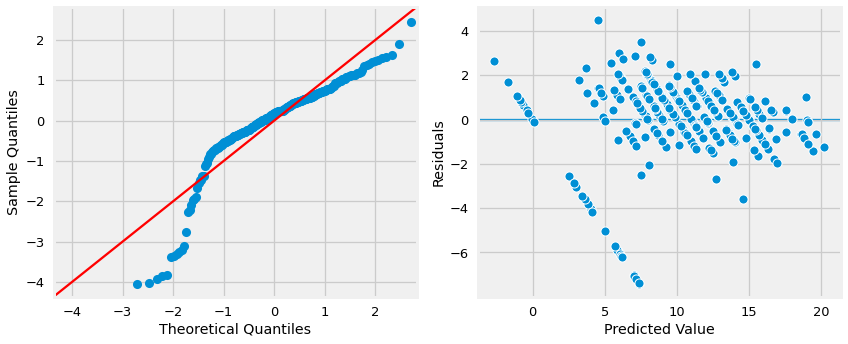

In [25]:
## instantiate an OLS model WITH the training data.
model_raw = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result_raw = model_raw.fit()
sf.evaluate_ols(result_raw,X_train_df, y_train)

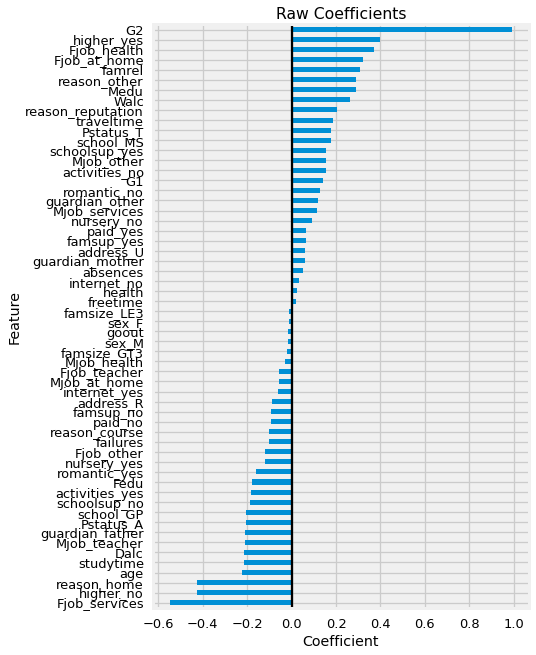

In [26]:
fig_raw = sf.plot_coeffs(result_raw, ohe_cols, include_const=True,title="Raw Coefficients")

In [27]:
# fig_raw_zips =sf.plot_coeffs(result_raw, figsize=(6,12),
#                            include_const=True,title="Raw Coefficients")

### Raw Numeric - with Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     34.46
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           6.10e-82
Time:                        14:43:26   Log-Likelihood:                -598.96
No. Observations:                 296   AIC:                             1282.
Df Residuals:                     254   BIC:                             1437.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.2208      0.121     -1.824      0.069      -0.459       0.018
Medu                  0.2916      0.178      1.637      0.103      -0.059       0.642
Fedu                 -0.1788      0.156     -1.149      0.252      -0.485       0.128
traveltime            0.1874      0.187      1.001      0.318      -0.181       0.556
studytime            -0.2153      0.167     -1.293      0.197      -0.543       0.113
failures             -0.1008      0.195     -0.517      0.606      -0.485       0.283
famrel                0.3099      0.139      2.231      0.027       0.036       0.584
freetime              0.0192      0.134      0.144      0.886      -0.244       0.283
goout                -0.0160      0.127     -0.126      0.900      -0.266       0.234
Dalc                 -0.2123      0.183     -1.163      0.246      -0.572       0.147
Walc                  0.2618      0.138      1.890      0.060      -0.011       0.534
health                0.0251      0.089      0.283      0.777      -0.149       0.200
absences              0.0532      0.017      3.177      0.002       0.020       0.086
G1                    0.1408      0.073      1.919      0.056      -0.004       0.285
G2                    0.9912      0.063     15.678      0.000       0.867       1.116
school_GP            -0.2040      0.217     -0.942      0.347      -0.631       0.223
school_MS             0.1785      0.313      0.570      0.569      -0.438       0.795
sex_F                -0.0099      0.194     -0.051      0.959      -0.391       0.371
sex_M                -0.0156      0.213     -0.073      0.942      -0.435       0.404
address_R            -0.0864      0.222     -0.389      0.698      -0.524       0.351
address_U             0.0609      0.211      0.288      0.774      -0.356       0.477
famsize_GT3          -0.0174      0.197     -0.088      0.930      -0.406       0.371
famsize_LE3          -0.0081      0.198     -0.041      0.967      -0.398       0.381
Pstatus_A            -0.2050      0.252     -0.813      0.417      -0.702       0.292
Pstatus_T             0.1795      0.247      0.725      0.469      -0.308       0.667
Mjob_at_home         -0.0571      0.338     -0.169      0.866      -0.722       0.608
Mjob_health          -0.0269      0.407     -0.066      0.947      -0.828       0.774
Mjob_other            0.1558      0.245      0.635      0.526      -0.327       0.639
Mjob_services         0.1132      0.242      0.468      0.640      -0.363       0.589
Mjob_teacher         -0.2105      0.334     -0.629      0.530      -0.869       0.448
Fjob_at_home          0.3203      0.473      0.677      0.499      -0.611       1.251
Fjob_health           0.3721      0.469      0.793      0.429      -0.552       1.297
Fjob_other           -0.1183      0.254     -0.465      0.642      -0.619

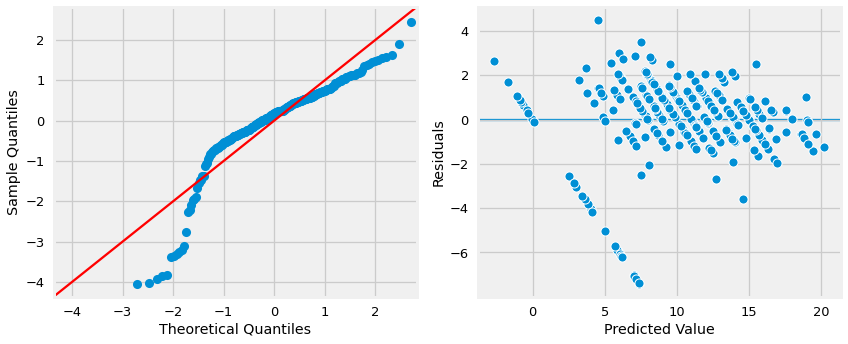

In [28]:
## instantiate an OLS model WITH the training data.
model_raw_cnst = sm.OLS(y_train, X_train_df_cnst)

## Fit the model and view the summary
result_raw_cnst = model_raw_cnst.fit()
sf.evaluate_ols(result_raw_cnst,X_train_df_cnst, y_train)

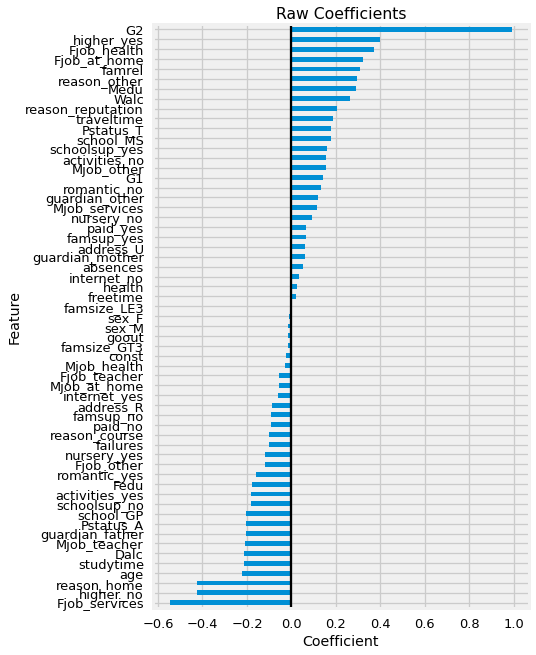

In [29]:
fig_raw =sf.plot_coeffs(result_raw_cnst, ohe_cols, include_const=True,title="Raw Coefficients")

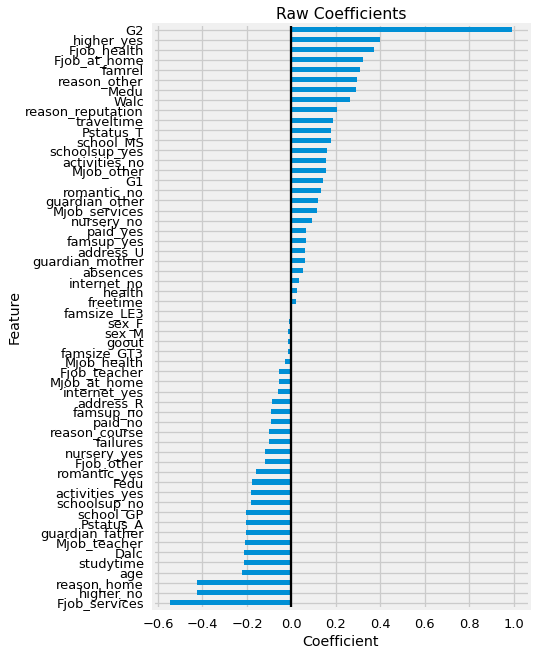

In [30]:
fig_raw =sf.plot_coeffs(result_raw_cnst, ohe_cols, include_const=False,title="Raw Coefficients")

In [31]:
# fig_raw_zips =sf.plot_coeffs(result_raw_cnst, nonohe_cols, figsize=(6,12),include_const=False,title="Raw Coefficients")

### Scaled Numeric - No Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     34.46
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           6.10e-82
Time:                        14:43:27   Log-Likelihood:                -598.96
No. Observations:                 296   AIC:                             1282.
Df Residuals:                     254   BIC:                             1437.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.2874      0.158     -1.824      0.069      -0.598       0.023
Medu                  0.3179      0.194      1.637      0.103      -0.065       0.700
Fedu                 -0.1943      0.169     -1.149      0.252      -0.527       0.139
traveltime            0.1386      0.138      1.001      0.318      -0.134       0.411
studytime            -0.1800      0.139     -1.293      0.197      -0.454       0.094
failures             -0.0729      0.141     -0.517      0.606      -0.350       0.205
famrel                0.2806      0.126      2.231      0.027       0.033       0.528
freetime              0.0194      0.135      0.144      0.886      -0.247       0.286
goout                -0.0181      0.143     -0.126      0.900      -0.300       0.264
Dalc                 -0.1886      0.162     -1.163      0.246      -0.508       0.131
Walc                  0.3431      0.182      1.890      0.060      -0.014       0.701
health                0.0353      0.125      0.283      0.777      -0.210       0.281
absences              0.4196      0.132      3.177      0.002       0.160       0.680
G1                    0.4725      0.246      1.919      0.056      -0.012       0.958
G2                    3.8146      0.243     15.678      0.000       3.335       4.294
school_GP             0.4938      0.220      2.248      0.025       0.061       0.926
school_MS             0.8764      0.242      3.618      0.000       0.399       1.353
sex_F                 0.6880      0.147      4.666      0.000       0.398       0.978
sex_M                 0.6822      0.152      4.502      0.000       0.384       0.981
address_R             0.6115      0.170      3.594      0.000       0.276       0.946
address_U             0.7587      0.164      4.621      0.000       0.435       1.082
famsize_GT3           0.6804      0.139      4.883      0.000       0.406       0.955
famsize_LE3           0.6898      0.143      4.815      0.000       0.408       0.972
Pstatus_A             0.4929      0.218      2.265      0.024       0.064       0.922
Pstatus_T             0.8773      0.198      4.425      0.000       0.487       1.268
Mjob_at_home          0.2221      0.334      0.664      0.507      -0.436       0.880
Mjob_health           0.2522      0.402      0.628      0.531      -0.539       1.044
Mjob_other            0.4350      0.243      1.791      0.074      -0.043       0.913
Mjob_services         0.3923      0.231      1.697      0.091      -0.063       0.848
Mjob_teacher          0.0686      0.330      0.208      0.836      -0.582       0.719
Fjob_at_home          0.5994      0.468      1.281      0.201      -0.322       1.521
Fjob_health           0.6512      0.469      1.387      0.167      -0.273       1.576
Fjob_other            0.1608      0.251      0.640      0.523      -0.334

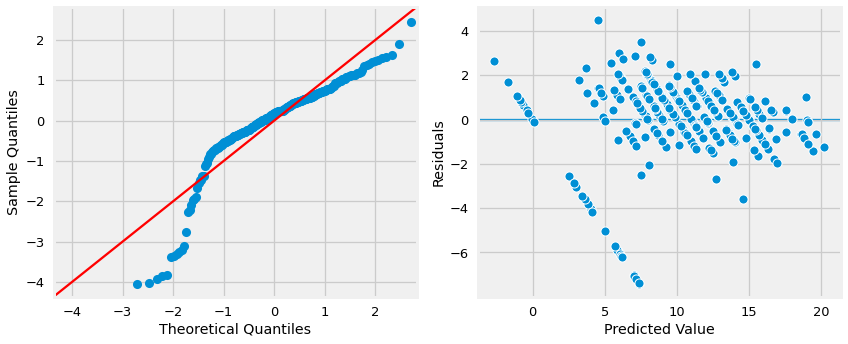

In [32]:
## instantiate an OLS model WITH the training data.
model_scaled = sm.OLS(y_train, X_train_scaled_df)

## Fit the model and view the summary
result_scaled = model_scaled.fit()
sf.evaluate_ols(result_scaled,X_train_scaled_df, y_train)

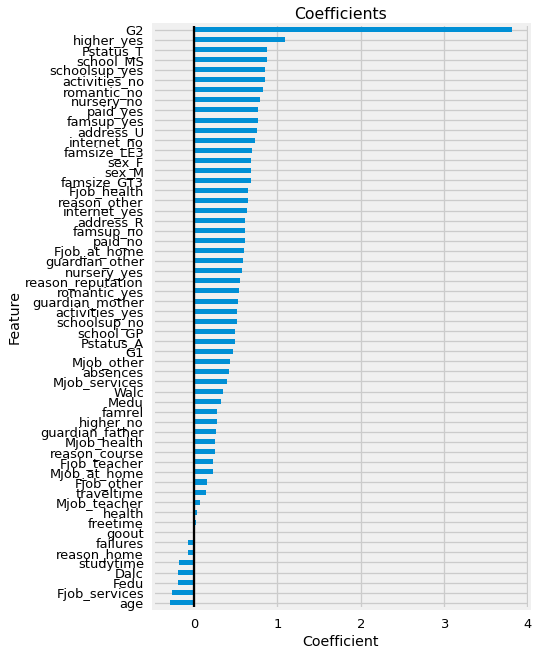

In [33]:
fig_scaled =sf.plot_coeffs(result_scaled,ohe_cols,include_const=True)

In [34]:
fig_scaled_zips =sf.plot_coeffs(result_scaled, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - with Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     34.46
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           6.10e-82
Time:                        14:43:28   Log-Likelihood:                -598.96
No. Observations:                 296   AIC:                             1282.
Df Residuals:                     254   BIC:                             1437.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.2874      0.158     -1.824      0.069      -0.598       0.023
Medu                  0.3179      0.194      1.637      0.103      -0.065       0.700
Fedu                 -0.1943      0.169     -1.149      0.252      -0.527       0.139
traveltime            0.1386      0.138      1.001      0.318      -0.134       0.411
studytime            -0.1800      0.139     -1.293      0.197      -0.454       0.094
failures             -0.0729      0.141     -0.517      0.606      -0.350       0.205
famrel                0.2806      0.126      2.231      0.027       0.033       0.528
freetime              0.0194      0.135      0.144      0.886      -0.247       0.286
goout                -0.0181      0.143     -0.126      0.900      -0.300       0.264
Dalc                 -0.1886      0.162     -1.163      0.246      -0.508       0.131
Walc                  0.3431      0.182      1.890      0.060      -0.014       0.701
health                0.0353      0.125      0.283      0.777      -0.210       0.281
absences              0.4196      0.132      3.177      0.002       0.160       0.680
G1                    0.4725      0.246      1.919      0.056      -0.012       0.958
G2                    3.8146      0.243     15.678      0.000       3.335       4.294
school_GP             0.4131      0.221      1.873      0.062      -0.021       0.847
school_MS             0.7956      0.240      3.309      0.001       0.322       1.269
sex_F                 0.6072      0.147      4.134      0.000       0.318       0.896
sex_M                 0.6015      0.151      3.995      0.000       0.305       0.898
address_R             0.5307      0.169      3.139      0.002       0.198       0.864
address_U             0.6780      0.164      4.138      0.000       0.355       1.001
famsize_GT3           0.5997      0.139      4.322      0.000       0.326       0.873
famsize_LE3           0.6090      0.142      4.282      0.000       0.329       0.889
Pstatus_A             0.4121      0.216      1.908      0.058      -0.013       0.838
Pstatus_T             0.7966      0.199      4.005      0.000       0.405       1.188
Mjob_at_home          0.1898      0.334      0.568      0.571      -0.469       0.848
Mjob_health           0.2199      0.402      0.547      0.585      -0.571       1.011
Mjob_other            0.4027      0.243      1.657      0.099      -0.076       0.881
Mjob_services         0.3600      0.231      1.558      0.121      -0.095       0.815
Mjob_teacher          0.0363      0.330      0.110      0.913      -0.614       0.686
Fjob_at_home          0.5671      0.468      1.213      0.226      -0.354       1.488
Fjob_health           0.6189      0.469      1.318      0.189      -0.306       1.543
Fjob_other            0.1285      0.252      0.511      0.610      -0.367

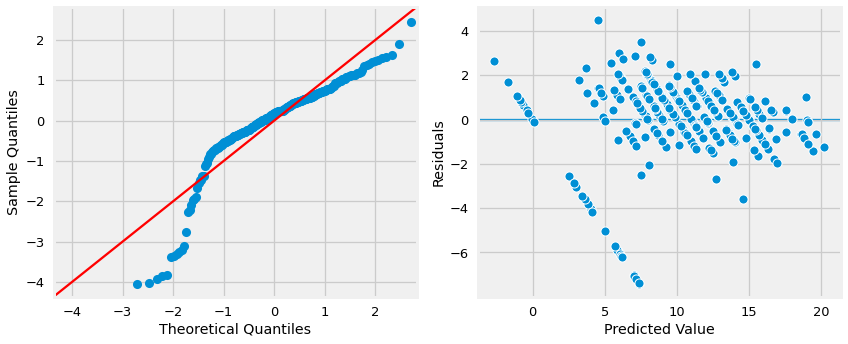

In [35]:
## instantiate an OLS model WITH the training data.
model_scaled_cnst = sm.OLS(y_train, X_train_scaled_df_cnst)

## Fit the model and view the summary
result_scaled_cnst = model_scaled_cnst.fit()
sf.evaluate_ols(result_scaled_cnst,X_train_scaled_df_cnst, y_train)

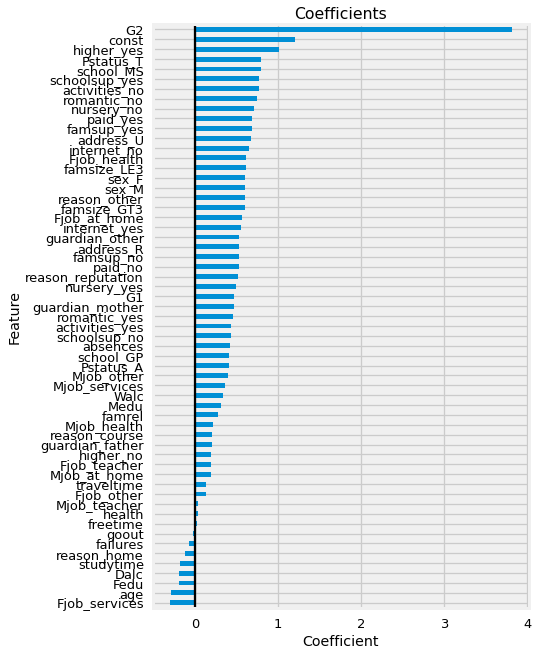

In [36]:
fig_scaled =sf.plot_coeffs(result_scaled_cnst,ohe_cols,include_const=True)

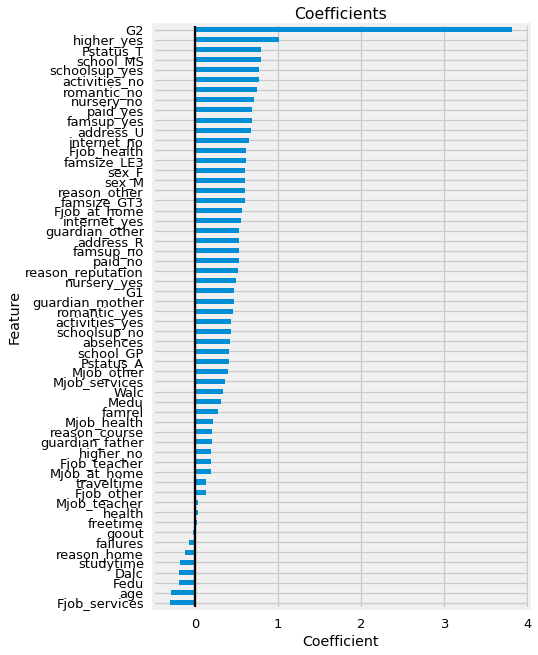

In [37]:
fig_scaled =sf.plot_coeffs(result_scaled_cnst,ohe_cols,include_const=False)

In [38]:
fig_scaled_zips =sf.plot_coeffs(result_scaled_cnst, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


## Modeling - No Outliers

### Raw Numeric - No Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     35.09
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           1.76e-76
Time:                        14:43:28   Log-Likelihood:                -513.92
No. Observations:                 266   AIC:                             1112.
Df Residuals:                     224   BIC:                             1262.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.3158      0.128     -2.471      0.014      -0.568      -0.064
Medu                  0.0525      0.182      0.289      0.773      -0.306       0.411
Fedu                 -0.0593      0.161     -0.368      0.713      -0.377       0.258
traveltime            0.0109      0.219      0.050      0.960      -0.420       0.442
studytime             0.0265      0.168      0.157      0.875      -0.305       0.358
failures             -0.5692      0.279     -2.043      0.042      -1.118      -0.020
famrel                0.3158      0.163      1.943      0.053      -0.005       0.636
freetime             -0.0302      0.133     -0.228      0.820      -0.292       0.231
goout                 0.1572      0.126      1.252      0.212      -0.090       0.405
Dalc                 -0.1502      0.218     -0.688      0.492      -0.581       0.280
Walc                 -0.0127      0.141     -0.090      0.928      -0.290       0.265
health                0.1844      0.093      1.985      0.048       0.001       0.367
absences              0.1185      0.022      5.447      0.000       0.076       0.161
G1                    0.1623      0.075      2.156      0.032       0.014       0.311
G2                    0.9824      0.068     14.543      0.000       0.849       1.116
school_GP            -0.2733      0.218     -1.252      0.212      -0.703       0.157
school_MS             0.4420      0.317      1.392      0.165      -0.184       1.068
sex_F                -0.0549      0.217     -0.253      0.801      -0.484       0.374
sex_M                 0.2236      0.216      1.033      0.303      -0.203       0.650
address_R             0.1067      0.246      0.434      0.665      -0.378       0.591
address_U             0.0619      0.220      0.281      0.779      -0.372       0.496
famsize_GT3           0.0804      0.210      0.382      0.703      -0.334       0.495
famsize_LE3           0.0883      0.218      0.405      0.686      -0.341       0.518
Pstatus_A             0.3026      0.278      1.087      0.278      -0.246       0.851
Pstatus_T            -0.1339      0.272     -0.493      0.623      -0.669       0.401
Mjob_at_home          0.2955      0.344      0.860      0.391      -0.382       0.973
Mjob_health           0.1904      0.361      0.527      0.599      -0.522       0.903
Mjob_other           -0.0620      0.240     -0.258      0.797      -0.535       0.411
Mjob_services        -0.3355      0.242     -1.388      0.167      -0.812       0.141
Mjob_teacher          0.0803      0.341      0.235      0.814      -0.592       0.752
Fjob_at_home         -0.1460      0.505     -0.289      0.773      -1.142       0.850
Fjob_health           0.1459      0.491      0.297      0.767      -0.821       1.113
Fjob_other            0.0648      0.267      0.243      0.808      -0.461

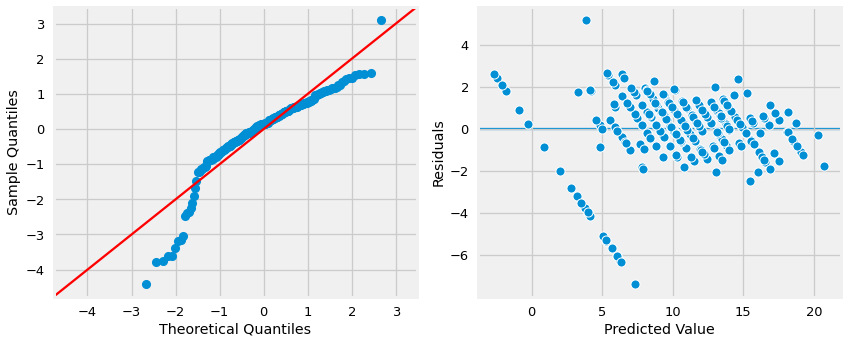

In [39]:
## instantiate an OLS model WITH the training data.
model_cln = sm.OLS(y_train_cln, X_train_df_cln)

## Fit the model and view the summary
result_cln = model_cln.fit()
sf.evaluate_ols(result_cln,X_train_df_cln, y_train_cln)

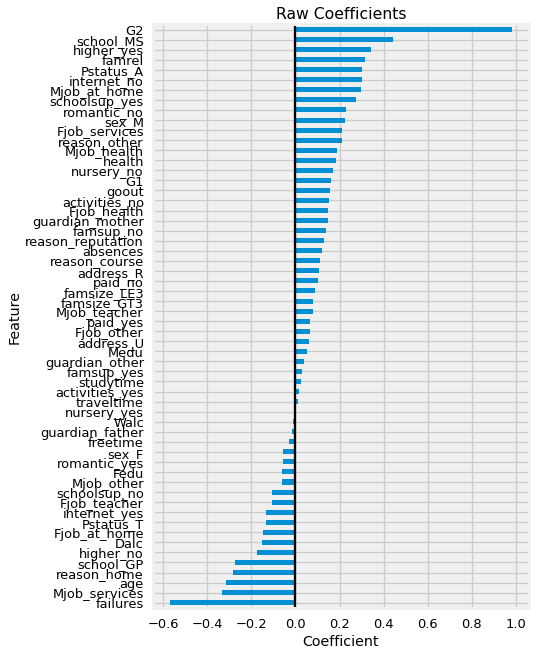

In [40]:
fig_raw =sf.plot_coeffs(result_cln, ohe_cols, include_const=True,title="Raw Coefficients")

In [41]:
fig_raw_zips =sf.plot_coeffs(result_cln, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Raw Numeric - with Constant

In [42]:
X_train_df_cln_cnst.describe()

age        Medu        Fedu  traveltime   studytime    failures  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean    16.642857    2.736842    2.578947    1.413534    2.060150    0.214286   
std      1.164039    1.098161    1.054804    0.609705    0.812723    0.502017   
min     15.000000    0.000000    1.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
50%     17.000000    3.000000    3.000000    1.000000    2.000000    0.000000   
75%     17.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     20.000000    4.000000    4.000000    3.000000    4.000000    2.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean     3.984962    3.218045    3.056391    1.379699    2.214286    3.597744   
std      0.786537    0.938392    1.064264    0.696759    1.176477    1.359743   
min      2.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    2.000000    1.000000    1.000000    3.000000   
50%      4.000000    3.000000    3.000000    1.000000    2.000000    4.000000   
75%      5.000000    4.000000    4.000000    2.000000    3.000000    5.000000   
max      5.000000    5.000000    5.000000    4.000000    5.000000    5.000000   

         absences          G1          G2   school_GP   school_MS       sex_F  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean     5.093985   11.146617   10.939850    0.879699    0.120301    0.533835   
std      5.916606    3.324740    3.667829    0.325926    0.325926    0.499794   
min      0.000000    3.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    8.000000    9.000000    1.000000    0.000000    0.000000   
50%      4.000000   11.000000   11.000000    1.000000    0.000000    1.000000   
75%      7.750000   14.000000   13.000000    1.000000    0.000000    1.000000   
max     28.000000   19.000000   19.000000    1.000000    1.000000    1.000000   

            sex_M   address_R   address_U  famsize_GT3  famsize_LE3  \
count  266.000000  266.000000  266.000000   266.000000   266.000000   
mean     0.466165    0.233083    0.766917     0.706767     0.293233   
std      0.499794    0.423591    0.423591     0.456103     0.456103   
min      0.000000    0.000000    0.000000     0.000000     0.000000   
25%      0.000000    0.000000    1.000000     0.000000     0.000000   
50%      0.000000    0.000000    1.000000     1.000000     0.000000   
75%      1.000000    0.000000    1.000000     1.000000     1.000000   
max      1.000000    1.000000    1.000000     1.000000     1.000000   

        Pstatus_A   Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
count  266.000000  266.000000    266.000000   266.000000  266.000000   
mean     0.078947    0.921053      0.154135     0.105263    0.342105   
std      0.270165    0.270165      0.361759     0.307471    0.475309   
min      0.000000    0.000000      0.000000     0.000000    0.000000   
25%      0.000000    1.000000      0.000000     0.000000    0.000000   
50%      0.000000    1.000000      0.000000     0.000000    0.000000   
75%      0.000000    1.000000      0.000000     0.000000    1.000000   
max      1.000000    1.000000      1.000000     1.000000    1.000000   

       Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
count     266.000000    266.000000    266.000000   266.000000  266.000000   
mean        0.248120      0.150376      0.048872     0.045113    0.571429   
std         0.432736      0.358113      0.216007     0.207943    0.495805   
min         0.000000      0.000000      0.000000     0.000000    0.000000   
25%         0.000000      0.000000      0.000000     0.000000    0.000000   
50%         0.000000      0.000000      0.000000     0.000000    1.000000

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     35.09
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           1.76e-76
Time:                        14:43:29   Log-Likelihood:                -513.92
No. Observations:                 266   AIC:                             1112.
Df Residuals:                     224   BIC:                             1262.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.3158      0.128     -2.471      0.014      -0.568      -0.064
Medu                  0.0525      0.182      0.289      0.773      -0.306       0.411
Fedu                 -0.0593      0.161     -0.368      0.713      -0.377       0.258
traveltime            0.0109      0.219      0.050      0.960      -0.420       0.442
studytime             0.0265      0.168      0.157      0.875      -0.305       0.358
failures             -0.5692      0.279     -2.043      0.042      -1.118      -0.020
famrel                0.3158      0.163      1.943      0.053      -0.005       0.636
freetime             -0.0302      0.133     -0.228      0.820      -0.292       0.231
goout                 0.1572      0.126      1.252      0.212      -0.090       0.405
Dalc                 -0.1502      0.218     -0.688      0.492      -0.581       0.280
Walc                 -0.0127      0.141     -0.090      0.928      -0.290       0.265
health                0.1844      0.093      1.985      0.048       0.001       0.367
absences              0.1185      0.022      5.447      0.000       0.076       0.161
G1                    0.1623      0.075      2.156      0.032       0.014       0.311
G2                    0.9824      0.068     14.543      0.000       0.849       1.116
school_GP            -0.2832      0.211     -1.340      0.182      -0.700       0.133
school_MS             0.4320      0.303      1.428      0.155      -0.164       1.028
sex_F                -0.0649      0.203     -0.320      0.750      -0.465       0.335
sex_M                 0.2137      0.202      1.058      0.291      -0.184       0.612
address_R             0.0968      0.232      0.418      0.677      -0.360       0.553
address_U             0.0520      0.208      0.250      0.803      -0.357       0.461
famsize_GT3           0.0705      0.196      0.360      0.720      -0.316       0.457
famsize_LE3           0.0783      0.203      0.386      0.700      -0.322       0.478
Pstatus_A             0.2926      0.267      1.097      0.274      -0.233       0.818
Pstatus_T            -0.1439      0.261     -0.552      0.582      -0.658       0.370
Mjob_at_home          0.2915      0.343      0.850      0.396      -0.385       0.968
Mjob_health           0.1864      0.359      0.519      0.605      -0.522       0.895
Mjob_other           -0.0660      0.239     -0.276      0.783      -0.538       0.406
Mjob_services        -0.3394      0.239     -1.417      0.158      -0.811       0.132
Mjob_teacher          0.0763      0.339      0.225      0.822      -0.591       0.744
Fjob_at_home         -0.1500      0.504     -0.298      0.766      -1.143       0.843
Fjob_health           0.1420      0.491      0.289      0.773      -0.825       1.109
Fjob_other            0.0608      0.265      0.229      0.819      -0.462

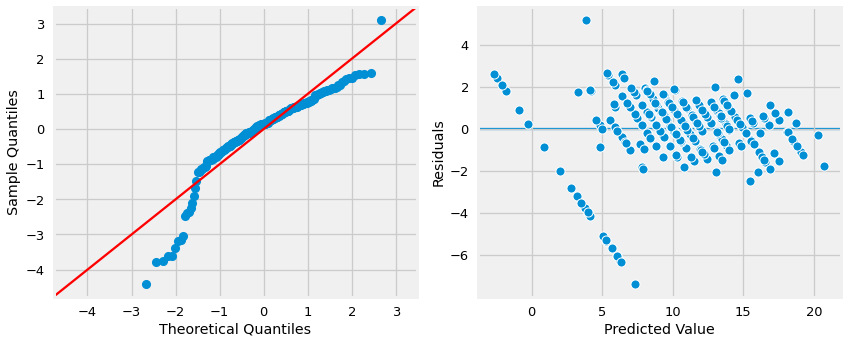

In [43]:
## instantiate an OLS model WITH the training data.
model_cln_cnst = sm.OLS(y_train_cln, X_train_df_cln_cnst)

## Fit the model and view the summary
result_cln_cnst = model_cln_cnst.fit()
sf.evaluate_ols(result_cln_cnst,X_train_df_cln_cnst, y_train_cln)

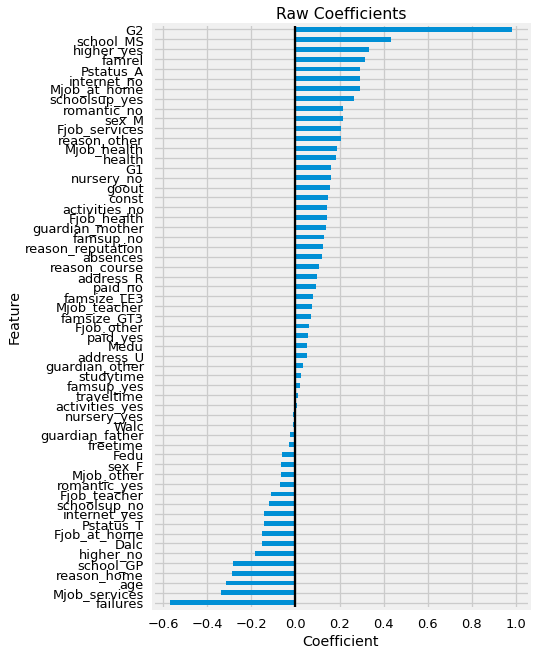

In [44]:
fig_raw =sf.plot_coeffs(result_cln_cnst, ohe_cols, include_const=True,title="Raw Coefficients")

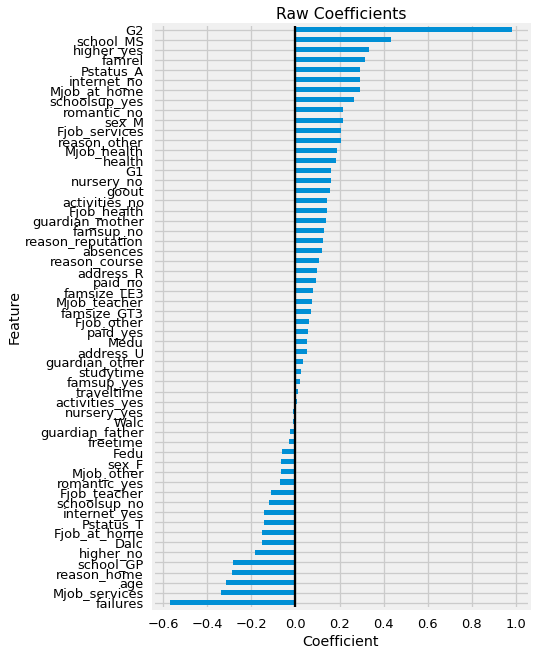

In [45]:
fig_raw =sf.plot_coeffs(result_cln_cnst, ohe_cols, include_const=False,title="Raw Coefficients")

In [46]:
fig_raw_zips =sf.plot_coeffs(result_cln_cnst, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - No Constant

In [47]:
X_train_scaled_df_cln.describe()

age          Medu          Fedu    traveltime     studytime  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean   4.090295e-16 -3.005115e-17  1.335607e-17  4.841574e-17  2.671213e-17   
std    1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00   
min   -1.414003e+00 -2.496902e+00 -1.499732e+00 -6.795304e-01 -1.306901e+00   
25%   -5.533053e-01 -6.722428e-01 -5.499018e-01 -6.795304e-01 -7.415040e-02   
50%    3.073919e-01  2.400867e-01  3.999286e-01 -6.795304e-01 -7.415040e-02   
75%    3.073919e-01  1.152416e+00  3.999286e-01  9.636977e-01 -7.415040e-02   
max    2.889483e+00  1.152416e+00  1.349759e+00  2.606926e+00  2.391350e+00   

           failures        famrel      freetime         goout          Dalc  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean   5.342427e-17  9.349247e-17 -5.676328e-17 -4.340722e-17  4.173771e-17   
std    1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00   
min   -4.276537e-01 -2.528429e+00 -2.368122e+00 -1.935862e+00 -5.459779e-01   
25%   -4.276537e-01  1.915477e-02 -2.327985e-01 -9.944738e-01 -5.459779e-01   
50%   -4.276537e-01  1.915477e-02 -2.327985e-01 -5.308579e-02 -5.459779e-01   
75%   -4.276537e-01  1.292947e+00  8.348635e-01  8.883022e-01  8.919440e-01   
max    3.563781e+00  1.292947e+00  1.902525e+00  1.829690e+00  3.767788e+00   

               Walc        health      absences            G1            G2  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean  -1.368997e-16 -3.005115e-17 -3.339017e-18  5.175476e-17  1.235436e-16   
std    1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00   
min   -1.034083e+00 -1.914069e+00 -8.625869e-01 -2.454921e+00 -2.988272e+00   
25%   -1.034083e+00 -4.404297e-01 -8.625869e-01 -9.482090e-01 -5.298791e-01   
50%   -1.824853e-01  2.963898e-01 -1.852493e-01 -4.418178e-02  1.643036e-02   
75%    6.691127e-01  1.033209e+00  4.497547e-01  8.598454e-01  5.627399e-01   
max    2.372309e+00  1.033209e+00  3.878777e+00  2.366557e+00  2.201668e+00   

        school_GP   school_MS       sex_F       sex_M   address_R   address_U  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean     0.879699    0.120301    0.533835    0.466165    0.233083    0.766917   
std      0.325926    0.325926    0.499794    0.499794    0.423591    0.423591   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
50%      1.000000    0.000000    1.000000    0.000000    0.000000    1.000000   
75%      1.000000    0.000000    1.000000    1.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       famsize_GT3  famsize_LE3   Pstatus_A   Pstatus_T  Mjob_at_home  \
count   266.000000   266.000000  266.000000  266.000000    266.000000   
mean      0.706767     0.293233    0.078947    0.921053      0.154135   
std       0.456103     0.456103    0.270165    0.270165      0.361759   
min       0.000000     0.000000    0.000000    0.000000      0.000000   
25%       0.000000     0.000000    0.000000    1.000000      0.000000   
50%       1.000000     0.000000    0.000000    1.000000      0.000000   
75%       1.000000     1.000000    0.000000    1.000000      0.000000   
max       1.000000     1.000000    1.000000    1.000000      1.000000   

       Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  Fjob_at_home  \
count   266.000000  266.000000     266.000000    266.000000    266.000000   
mean      0.105263    0.342105       0.248120      0.150376      0.048872   
std       0.307471    0.475309       0.432736      0.358113      0.216007   
min       0.000000    0.000000       0.000000      0.000000      0.000000   
25%       0.000000    0.000000       0.000000      0.000000      0.000000   
50%       0.000000    0.000000

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     35.09
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           1.76e-76
Time:                        14:43:30   Log-Likelihood:                -513.92
No. Observations:                 266   AIC:                             1112.
Df Residuals:                     224   BIC:                             1262.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.3669      0.148     -2.471      0.014      -0.660      -0.074
Medu                  0.0576      0.199      0.289      0.773      -0.336       0.451
Fedu                 -0.0624      0.170     -0.368      0.713      -0.397       0.272
traveltime            0.0067      0.133      0.050      0.960      -0.256       0.269
studytime             0.0215      0.137      0.157      0.875      -0.248       0.291
failures             -0.2852      0.140     -2.043      0.042      -0.560      -0.010
famrel                0.2479      0.128      1.943      0.053      -0.004       0.499
freetime             -0.0283      0.124     -0.228      0.820      -0.273       0.217
goout                 0.1670      0.133      1.252      0.212      -0.096       0.430
Dalc                 -0.1045      0.152     -0.688      0.492      -0.404       0.195
Walc                 -0.0149      0.165     -0.090      0.928      -0.341       0.311
health                0.2503      0.126      1.985      0.048       0.002       0.499
absences              0.7000      0.129      5.447      0.000       0.447       0.953
G1                    0.5385      0.250      2.156      0.032       0.046       1.031
G2                    3.5965      0.247     14.543      0.000       3.109       4.084
school_GP             0.3890      0.211      1.847      0.066      -0.026       0.804
school_MS             1.1043      0.228      4.846      0.000       0.655       1.553
sex_F                 0.6073      0.144      4.208      0.000       0.323       0.892
sex_M                 0.8859      0.145      6.091      0.000       0.599       1.172
address_R             0.7690      0.176      4.377      0.000       0.423       1.115
address_U             0.7242      0.161      4.495      0.000       0.407       1.042
famsize_GT3           0.7427      0.137      5.415      0.000       0.472       1.013
famsize_LE3           0.7506      0.144      5.206      0.000       0.466       1.035
Pstatus_A             0.9649      0.236      4.092      0.000       0.500       1.430
Pstatus_T             0.5284      0.209      2.534      0.012       0.117       0.939
Mjob_at_home          0.5604      0.341      1.642      0.102      -0.112       1.233
Mjob_health           0.4553      0.352      1.293      0.197      -0.239       1.149
Mjob_other            0.2029      0.240      0.846      0.398      -0.269       0.675
Mjob_services        -0.0706      0.231     -0.305      0.760      -0.526       0.385
Mjob_teacher          0.3452      0.330      1.045      0.297      -0.305       0.996
Fjob_at_home          0.1189      0.499      0.238      0.812      -0.864       1.101
Fjob_health           0.4109      0.494      0.831      0.407      -0.563       1.385
Fjob_other            0.3297      0.258      1.279      0.202      -0.178

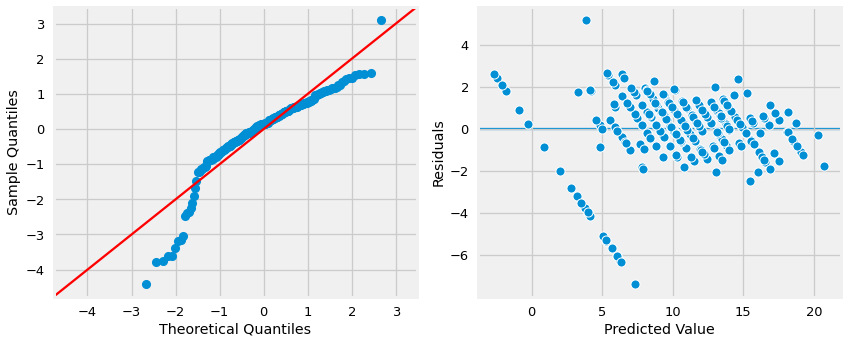

In [48]:
## instantiate an OLS model WITH the training data.
model_cln_scaled = sm.OLS(y_train_cln, X_train_scaled_df_cln)

## Fit the model and view the summary
result_cln_scaled = model_cln_scaled.fit()
sf.evaluate_ols(result_cln_scaled,X_train_scaled_df_cln, y_train_cln)

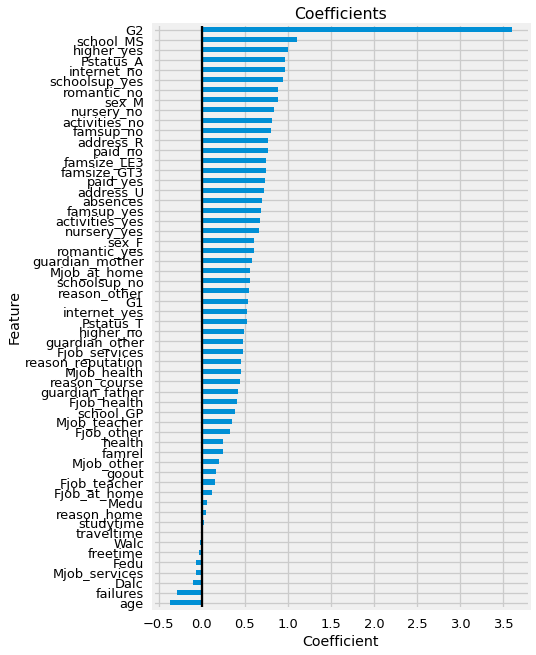

In [49]:
fig_scaled =sf.plot_coeffs(result_cln_scaled,ohe_cols,include_const=True)

In [50]:
fig_scaled_zips =sf.plot_coeffs(result_cln_scaled, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - with Constant

In [51]:
X_train_scaled_df_cln_cnst.describe()

age          Medu          Fedu    traveltime     studytime  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean   4.090295e-16 -3.005115e-17  1.335607e-17  4.841574e-17  2.671213e-17   
std    1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00   
min   -1.414003e+00 -2.496902e+00 -1.499732e+00 -6.795304e-01 -1.306901e+00   
25%   -5.533053e-01 -6.722428e-01 -5.499018e-01 -6.795304e-01 -7.415040e-02   
50%    3.073919e-01  2.400867e-01  3.999286e-01 -6.795304e-01 -7.415040e-02   
75%    3.073919e-01  1.152416e+00  3.999286e-01  9.636977e-01 -7.415040e-02   
max    2.889483e+00  1.152416e+00  1.349759e+00  2.606926e+00  2.391350e+00   

           failures        famrel      freetime         goout          Dalc  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean   5.342427e-17  9.349247e-17 -5.676328e-17 -4.340722e-17  4.173771e-17   
std    1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00   
min   -4.276537e-01 -2.528429e+00 -2.368122e+00 -1.935862e+00 -5.459779e-01   
25%   -4.276537e-01  1.915477e-02 -2.327985e-01 -9.944738e-01 -5.459779e-01   
50%   -4.276537e-01  1.915477e-02 -2.327985e-01 -5.308579e-02 -5.459779e-01   
75%   -4.276537e-01  1.292947e+00  8.348635e-01  8.883022e-01  8.919440e-01   
max    3.563781e+00  1.292947e+00  1.902525e+00  1.829690e+00  3.767788e+00   

               Walc        health      absences            G1            G2  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean  -1.368997e-16 -3.005115e-17 -3.339017e-18  5.175476e-17  1.235436e-16   
std    1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00  1.001885e+00   
min   -1.034083e+00 -1.914069e+00 -8.625869e-01 -2.454921e+00 -2.988272e+00   
25%   -1.034083e+00 -4.404297e-01 -8.625869e-01 -9.482090e-01 -5.298791e-01   
50%   -1.824853e-01  2.963898e-01 -1.852493e-01 -4.418178e-02  1.643036e-02   
75%    6.691127e-01  1.033209e+00  4.497547e-01  8.598454e-01  5.627399e-01   
max    2.372309e+00  1.033209e+00  3.878777e+00  2.366557e+00  2.201668e+00   

        school_GP   school_MS       sex_F       sex_M   address_R   address_U  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean     0.879699    0.120301    0.533835    0.466165    0.233083    0.766917   
std      0.325926    0.325926    0.499794    0.499794    0.423591    0.423591   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
50%      1.000000    0.000000    1.000000    0.000000    0.000000    1.000000   
75%      1.000000    0.000000    1.000000    1.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       famsize_GT3  famsize_LE3   Pstatus_A   Pstatus_T  Mjob_at_home  \
count   266.000000   266.000000  266.000000  266.000000    266.000000   
mean      0.706767     0.293233    0.078947    0.921053      0.154135   
std       0.456103     0.456103    0.270165    0.270165      0.361759   
min       0.000000     0.000000    0.000000    0.000000      0.000000   
25%       0.000000     0.000000    0.000000    1.000000      0.000000   
50%       1.000000     0.000000    0.000000    1.000000      0.000000   
75%       1.000000     1.000000    0.000000    1.000000      0.000000   
max       1.000000     1.000000    1.000000    1.000000      1.000000   

       Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  Fjob_at_home  \
count   266.000000  266.000000     266.000000    266.000000    266.000000   
mean      0.105263    0.342105       0.248120      0.150376      0.048872   
std       0.307471    0.475309       0.432736      0.358113      0.216007   
min       0.000000    0.000000       0.000000      0.000000      0.000000   
25%       0.000000    0.000000       0.000000      0.000000      0.000000   
50%       0.000000    0.000000

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     35.09
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           1.76e-76
Time:                        14:43:31   Log-Likelihood:                -513.92
No. Observations:                 266   AIC:                             1112.
Df Residuals:                     224   BIC:                             1262.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.3669      0.148     -2.471      0.014      -0.660      -0.074
Medu                  0.0576      0.199      0.289      0.773      -0.336       0.451
Fedu                 -0.0624      0.170     -0.368      0.713      -0.397       0.272
traveltime            0.0067      0.133      0.050      0.960      -0.256       0.269
studytime             0.0215      0.137      0.157      0.875      -0.248       0.291
failures             -0.2852      0.140     -2.043      0.042      -0.560      -0.010
famrel                0.2479      0.128      1.943      0.053      -0.004       0.499
freetime             -0.0283      0.124     -0.228      0.820      -0.273       0.217
goout                 0.1670      0.133      1.252      0.212      -0.096       0.430
Dalc                 -0.1045      0.152     -0.688      0.492      -0.404       0.195
Walc                 -0.0149      0.165     -0.090      0.928      -0.341       0.311
health                0.2503      0.126      1.985      0.048       0.002       0.499
absences              0.7000      0.129      5.447      0.000       0.447       0.953
G1                    0.5385      0.250      2.156      0.032       0.046       1.031
G2                    3.5965      0.247     14.543      0.000       3.109       4.084
school_GP             0.3010      0.211      1.427      0.155      -0.115       0.717
school_MS             1.0162      0.226      4.491      0.000       0.570       1.462
sex_F                 0.5193      0.143      3.622      0.000       0.237       0.802
sex_M                 0.7979      0.144      5.527      0.000       0.513       1.082
address_R             0.6810      0.174      3.913      0.000       0.338       1.024
address_U             0.6362      0.161      3.949      0.000       0.319       0.954
famsize_GT3           0.6547      0.137      4.796      0.000       0.386       0.924
famsize_LE3           0.6625      0.143      4.641      0.000       0.381       0.944
Pstatus_A             0.8769      0.234      3.752      0.000       0.416       1.337
Pstatus_T             0.4404      0.210      2.101      0.037       0.027       0.853
Mjob_at_home          0.5252      0.342      1.537      0.126      -0.148       1.198
Mjob_health           0.4201      0.352      1.194      0.234      -0.273       1.113
Mjob_other            0.1677      0.240      0.699      0.485      -0.305       0.640
Mjob_services        -0.1058      0.231     -0.458      0.647      -0.561       0.349
Mjob_teacher          0.3100      0.330      0.940      0.348      -0.340       0.960
Fjob_at_home          0.0837      0.498      0.168      0.867      -0.898       1.065
Fjob_health           0.3756      0.494      0.760      0.448      -0.598       1.350
Fjob_other            0.2945      0.258      1.142      0.255      -0.214

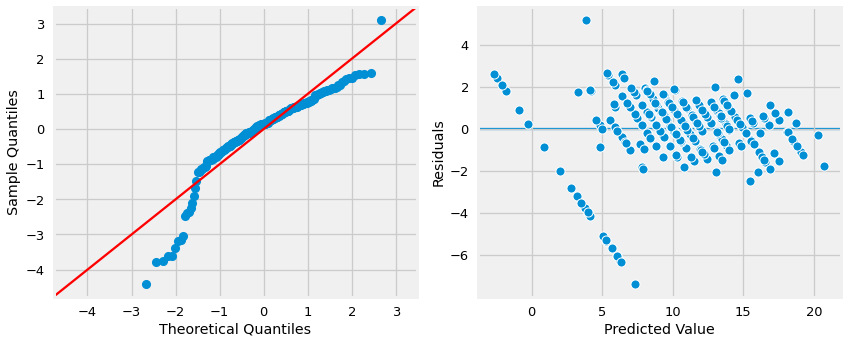

In [52]:
## instantiate an OLS model WITH the training data.
model_cln_scaled_cnst = sm.OLS(y_train_cln, X_train_scaled_df_cln_cnst)

## Fit the model and view the summary
result_cln_scaled_cnst = model_cln_scaled_cnst.fit()
sf.evaluate_ols(result_cln_scaled_cnst,X_train_scaled_df_cln_cnst, y_train_cln)

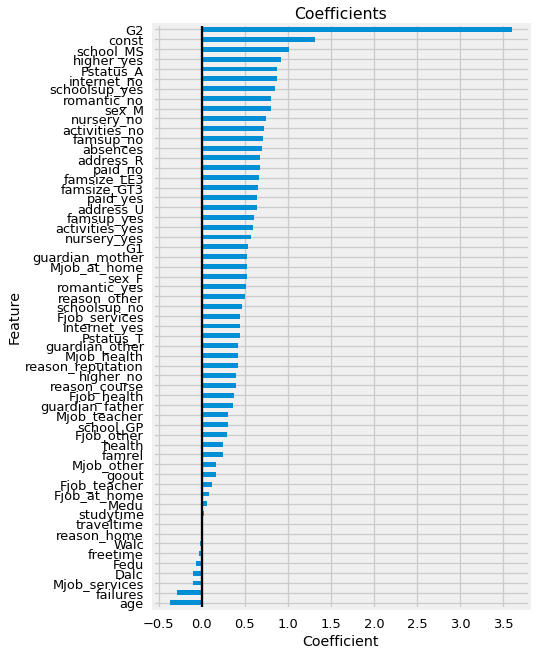

In [53]:
fig_scaled =sf.plot_coeffs(result_cln_scaled_cnst,ohe_cols,include_const=True)

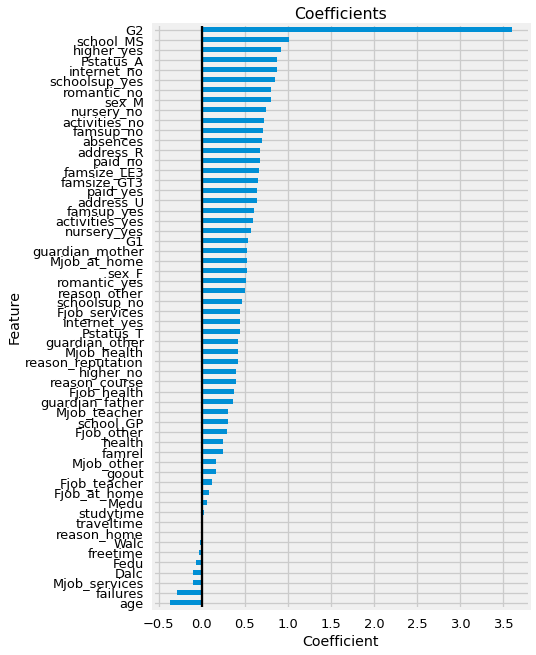

In [54]:
fig_scaled =sf.plot_coeffs(result_cln_scaled_cnst,ohe_cols,include_const=False)

# Adding Explanations

## Sklearn LinearRegression

> Pick 1 of the statsmodels models above to remake in sklearn for model explanations

In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
## Making new var name sfor sklearn - update these to change model
ols_results = result_scaled_cnst
# sf.evaluate_ols(ols_results,X_tr,y_tr)
X_tr = X_train_scaled_df_cnst
X_te = X_test_scaled_df_cnst
y_tr = y_train
y_te = y_test

## If const in orig df, 
fit_intercept = 'const' in X_tr.columns

if fit_intercept==True:
    X_tr = X_tr.drop(columns='const')
    X_te = X_te.drop(columns='const')
fit_intercept

True

In [57]:
linreg = LinearRegression(fit_intercept=fit_intercept)
linreg.fit(X_tr, y_tr)
print(f"Train R^2: {format(linreg.score(X_tr,y_tr),'.2f')}")
print(f"Test R^2: {format(linreg.score(X_te,y_te),'.2f')}")
linreg.get_params()

Train R^2: 0.85
Test R^2: 0.81


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [58]:
coeffs = sf.get_coeffs(linreg,X_tr,name='LinReg Coeffs')
coeffs#.head(20)

age                 -2.873861e-01
Medu                 3.179176e-01
Fedu                -1.942883e-01
traveltime           1.385787e-01
studytime           -1.800160e-01
failures            -7.286600e-02
famrel               2.806296e-01
freetime             1.943847e-02
goout               -1.804789e-02
Dalc                -1.886337e-01
Walc                 3.431357e-01
health               3.534912e-02
absences             4.196041e-01
G1                   4.725100e-01
G2                   3.814609e+00
school_GP            2.038888e+10
school_MS            2.038888e+10
sex_F                2.355263e+09
sex_M                2.355263e+09
address_R           -2.220898e+09
address_U           -2.220898e+09
famsize_GT3         -1.025283e+09
famsize_LE3         -1.025283e+09
Pstatus_A           -2.523930e+09
Pstatus_T           -2.523930e+09
Mjob_at_home         2.027073e+09
Mjob_health          2.027073e+09
Mjob_other           2.027073e+09
Mjob_services        2.027073e+09
Mjob_teacher  

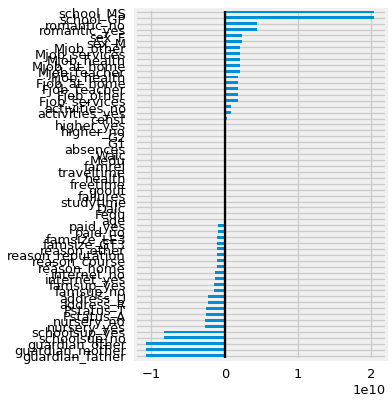

In [59]:
ax = coeffs.drop(ohe_cols).sort_values().plot(kind='barh',figsize=(4,6))
ax.axvline(0,color='black')

In [60]:
if len(ohe_cols)>1:
    ax = coeffs[ohe_cols].sort_values().plot(kind='barh',figsize=(4,6))
    ax.axvline(0,color='black')

In [61]:
## save 1 df of skelarn vs ols coeffs
compare_coeffs = pd.DataFrame({'OLS':ols_results.params,
                              'LinReg':coeffs}).round(2)
compare_coeffs['Agree?'] = compare_coeffs['OLS']==compare_coeffs['LinReg']

display(compare_coeffs.round(3))
compare_coeffs['Agree?'].value_counts(1)
#compare_coeffs.style.format({'OLS':"{:,.2f}","LinReg":"{:,.2f}"})

OLS        LinReg  Agree?
age               -0.29 -2.900000e-01    True
Medu               0.32  3.200000e-01    True
Fedu              -0.19 -1.900000e-01    True
traveltime         0.14  1.400000e-01    True
studytime         -0.18 -1.800000e-01    True
failures          -0.07 -7.000000e-02    True
famrel             0.28  2.800000e-01    True
freetime           0.02  2.000000e-02    True
goout             -0.02 -2.000000e-02    True
Dalc              -0.19 -1.900000e-01    True
Walc               0.34  3.400000e-01    True
health             0.04  4.000000e-02    True
absences           0.42  4.200000e-01    True
G1                 0.47  4.700000e-01    True
G2                 3.81  3.810000e+00    True
school_GP          0.41  2.038888e+10   False
school_MS          0.80  2.038888e+10   False
sex_F              0.61  2.355263e+09   False
sex_M              0.60  2.355263e+09   False
address_R          0.53 -2.220898e+09   False
address_U          0.68 -2.220898e+09   False
famsize_GT3        0.60 -1.025283e+09   False
famsize_LE3        0.61 -1.025283e+09   False
Pstatus_A          0.41 -2.523930e+09   False
Pstatus_T          0.80 -2.523930e+09   False
Mjob_at_home       0.19  2.027073e+09   False
Mjob_health        0.22  2.027073e+09   False
Mjob_other         0.40  2.027073e+09   False
Mjob_services      0.36  2.027073e+09   False
Mjob_teacher       0.04  2.027073e+09   False
Fjob_at_home       0.57  1.849508e+09   False
Fjob_health        0.62  1.849508e+09   False
Fjob_other         0.13  1.849508e+09   False
Fjob_services     -0.30  1.849508e+09   False
Fjob_teacher       0.19  1.849508e+09   False
reason_course      0.21 -1.105854e+09   False
reason_home       -0.12 -1.105854e+09   False
reason_other       0.60 -1.105854e+09   False
reason_reputation  0.51 -1.105854e+09   False
guardian_father    0.20 -1.068634e+10   False
guardian_mother    0.47 -1.068634e+10   False
guardian_other     0.53 -1.068634e+10   False
schoolsup_no       0.43 -8.308865e+09   False
schoolsup_yes      0.78 -8.308865e+09   False
famsup_no          0.53 -1.512565e+09   False
famsup_yes         0.68 -1.512565e+09   False
paid_no            0.52 -9.258273e+08   False
paid_yes           0.68 -9.258273e+08   False
activities_no      0.77  9.092248e+08   False
activities_yes     0.43  9.092248e+08   False
nursery_no         0.71 -2.650248e+09   False
nursery_yes        0.50 -2.650248e+09   False
higher_no          0.19  2.767975e+07   False
higher_yes         1.02  2.767975e+07   False
internet_no        0.65 -1.266718e+09   False
internet_yes       0.56 -1.266718e+09   False
romantic_no        0.75  4.386933e+09   False
romantic_yes       0.46  4.386933e+09   False
const              1.21  2.819572e+08   False

False    0.745763
True     0.254237
Name: Agree?, dtype: float64

In [62]:
compare_coeffs[compare_coeffs['Agree?']==True]

OLS  LinReg  Agree?
age        -0.29   -0.29    True
Medu        0.32    0.32    True
Fedu       -0.19   -0.19    True
traveltime  0.14    0.14    True
studytime  -0.18   -0.18    True
failures   -0.07   -0.07    True
famrel      0.28    0.28    True
freetime    0.02    0.02    True
goout      -0.02   -0.02    True
Dalc       -0.19   -0.19    True
Walc        0.34    0.34    True
health      0.04    0.04    True
absences    0.42    0.42    True
G1          0.47    0.47    True
G2          3.81    3.81    True

In [63]:
compare_coeffs[compare_coeffs['Agree?']==False]

OLS        LinReg  Agree?
school_GP          0.41  2.038888e+10   False
school_MS          0.80  2.038888e+10   False
sex_F              0.61  2.355263e+09   False
sex_M              0.60  2.355263e+09   False
address_R          0.53 -2.220898e+09   False
address_U          0.68 -2.220898e+09   False
famsize_GT3        0.60 -1.025283e+09   False
famsize_LE3        0.61 -1.025283e+09   False
Pstatus_A          0.41 -2.523930e+09   False
Pstatus_T          0.80 -2.523930e+09   False
Mjob_at_home       0.19  2.027073e+09   False
Mjob_health        0.22  2.027073e+09   False
Mjob_other         0.40  2.027073e+09   False
Mjob_services      0.36  2.027073e+09   False
Mjob_teacher       0.04  2.027073e+09   False
Fjob_at_home       0.57  1.849508e+09   False
Fjob_health        0.62  1.849508e+09   False
Fjob_other         0.13  1.849508e+09   False
Fjob_services     -0.30  1.849508e+09   False
Fjob_teacher       0.19  1.849508e+09   False
reason_course      0.21 -1.105854e+09   False
reason_home       -0.12 -1.105854e+09   False
reason_other       0.60 -1.105854e+09   False
reason_reputation  0.51 -1.105854e+09   False
guardian_father    0.20 -1.068634e+10   False
guardian_mother    0.47 -1.068634e+10   False
guardian_other     0.53 -1.068634e+10   False
schoolsup_no       0.43 -8.308865e+09   False
schoolsup_yes      0.78 -8.308865e+09   False
famsup_no          0.53 -1.512565e+09   False
famsup_yes         0.68 -1.512565e+09   False
paid_no            0.52 -9.258273e+08   False
paid_yes           0.68 -9.258273e+08   False
activities_no      0.77  9.092248e+08   False
activities_yes     0.43  9.092248e+08   False
nursery_no         0.71 -2.650248e+09   False
nursery_yes        0.50 -2.650248e+09   False
higher_no          0.19  2.767975e+07   False
higher_yes         1.02  2.767975e+07   False
internet_no        0.65 -1.266718e+09   False
internet_yes       0.56 -1.266718e+09   False
romantic_no        0.75  4.386933e+09   False
romantic_yes       0.46  4.386933e+09   False
const              1.21  2.819572e+08   False

In [64]:
compare_coeffs.style.bar()

> ISSUE WITH COEFFICIENTS NOT MATCHING - SEE IF TRUE FOR OTHER DATASETS. 

### Shap

In [65]:
import shap
shap.initjs()

shap.__version__

'0.41.0'

In [66]:
## sampling 200 rows from training data
X_shap = shap.sample(X_tr,nsamples=200,random_state=321)

In [67]:
## Creating explainer from model and getting shap values
explainer = shap.LinearExplainer(linreg,X_shap)
shap_values = explainer(X_shap)
shap_values.shape

(200, 58)

In [68]:
# [i for i in dir(shap_values) if not i.startswith("_")]

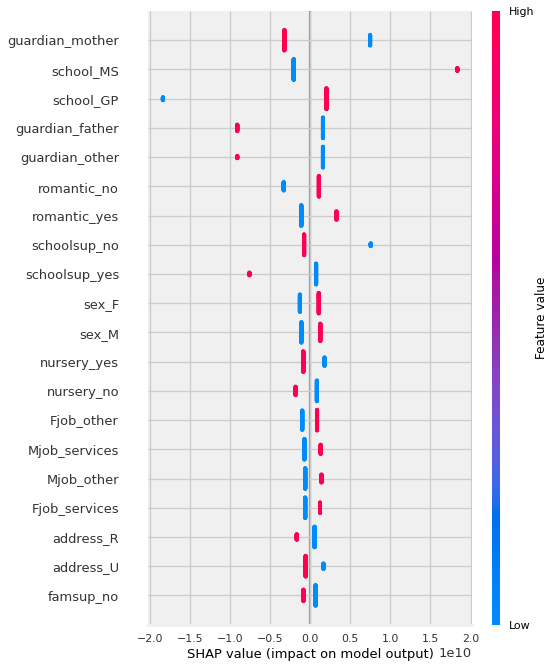

In [69]:
shap.summary_plot(shap_values)

In [70]:
explainer.expected_value

11.087698936462402

In [71]:
shap.force_plot(explainer.expected_value,shap_values= shap_values.values, features=X_shap)       

## RandomForest

In [72]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_tr,y_tr)

RandomForestRegressor()

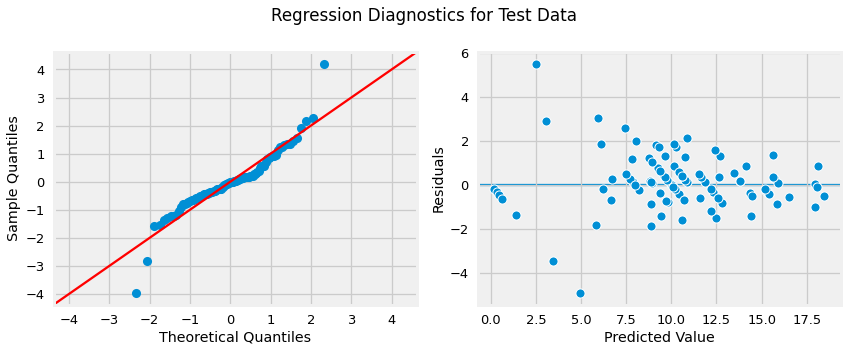

Score
Metric Split       
R^2    Train   0.98
       Test    0.91
RMSE   Train   0.67
       Test    1.28

In [73]:
scores = sf.evaluate_regression(rf_reg,X_te, y_te, X_train_df=X_tr, y_train=y_tr,
                            return_scores=True)

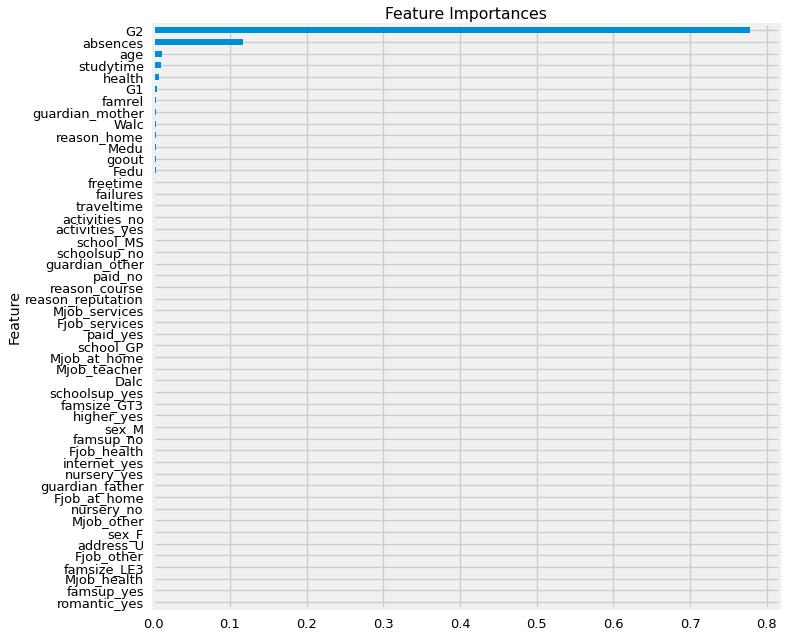

In [74]:
importances = sf.get_importance(rf_reg,X_test_df,top_n=50)

### Permutation Importance

In [75]:
from sklearn.inspection import permutation_importance
## Permutation importance takes a fit mode and test data. 
r = permutation_importance(linreg, X_tr, y_tr,
#                            n_repeats=30
                          )
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [76]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_tr.columns,
                           name = 'permutation importance')
permutation_importances

age                  9.268517e-03
Medu                 9.111100e-03
Fedu                 3.072924e-03
traveltime           2.021210e-03
studytime            3.027815e-03
failures             7.612515e-04
famrel               6.773530e-03
freetime             3.185070e-05
goout               -1.229025e-05
Dalc                 3.762509e-03
Walc                 1.316257e-02
health               1.854700e-04
absences             1.677395e-02
G1                   1.774954e-02
G2                   1.286951e+00
school_GP            3.908920e+18
school_MS            3.908920e+18
sex_F                1.254599e+17
sex_M                1.254599e+17
address_R            7.942126e+16
address_U            7.942126e+16
famsize_GT3          1.860623e+16
famsize_LE3          1.860623e+16
Pstatus_A            5.246114e+16
Pstatus_T            5.246114e+16
Mjob_at_home         5.025397e+16
Mjob_health          2.449565e+16
Mjob_other           8.131546e+16
Mjob_services        7.373949e+16
Mjob_teacher  

<AxesSubplot:>

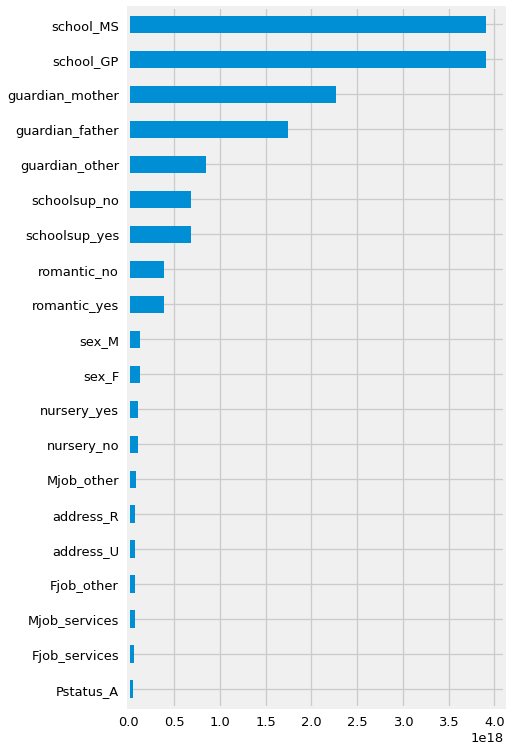

In [77]:
permutation_importances.sort_values().tail(20).plot(kind='barh',figsize=(6,12))

In [78]:
X_shap = shap.sample(X_tr,nsamples=200,random_state=321)

In [79]:
explainer = shap.TreeExplainer(rf_reg,X_shap)
shap_values = explainer(X_shap,check_additivity=False)

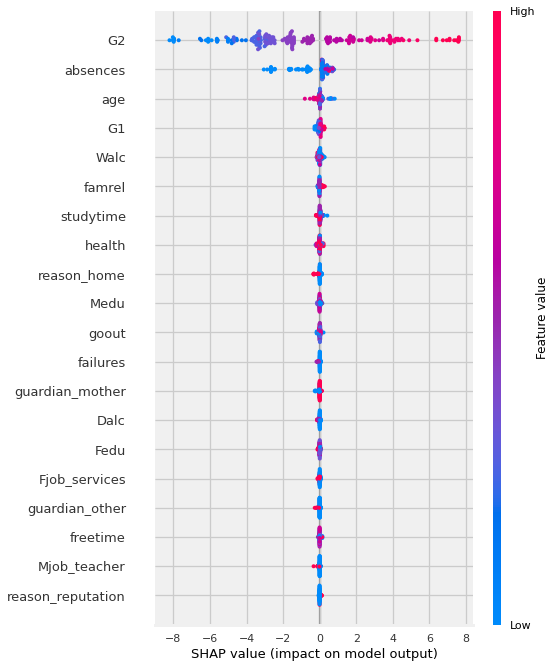

In [80]:
shap.summary_plot(shap_values)

In [81]:
shap.force_plot(explainer.expected_value,shap_values= shap_values.values, features=X_shap)       